# Import Packages

In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gseapy
import os

## Read data into scanpy
* needs to be transposed first to be loaded properly
* load into scanpy object

In [3]:
def transpose_csv(csv_path, output_csv_path='transposed.csv', delimiter=','):
    # code copied from: https://stackoverflow.com/questions/7156539/how-do-i-transpose-pivot-a-csv-file-with-python-without-loading-the-whole-file
    import csv
    
    print("easter egg")

    transposed_iterator = zip(*csv.reader(open(csv_path)))
    with open(output_csv_path, 'w') as out:
        for row in transposed_iterator:
            out.write(delimiter.join(row) + '\n')

raw_file = "../GSE125881_raw.expMatrix.csv" # read in the file here, ../ means folder above
transposed_file = "expMatrix_transposed.csv" #we needed to transpose the axes of the file
figpath = '../figures' #ATB, I am trying to save figures as I go?

if not os.path.exists(transposed_file):
    transpose_csv(raw_file, transposed_file)

In [4]:
# we see 62k cells and 20k genes
expr = sc.read_csv(transposed_file, first_column_names=True)
expr

AnnData object with n_obs × n_vars = 62167 × 20223

## Quality Control
* filter cells with < 200 genes
* filter genes with < 3 cells
* filter cells with > 10% mitochodrial genes

In [5]:
expr.var['mt'] = expr.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(expr, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
expr.obs.head()

n_genes_by_counts  total_counts  total_counts_mt  \
AAACCTGAGCGTCTAT-1               2500        8780.0            333.0   
AAACCTGCAATAGAGT-1               2549        8782.0            739.0   
AAACCTGCATGACGGA-1               3146       10911.0            540.0   
AAACCTGGTAGTGAAT-1               4310       18042.0           1167.0   
AAACCTGGTCTCCCTA-1               4628       24558.0           1217.0   

                    pct_counts_mt  
AAACCTGAGCGTCTAT-1       3.792711  
AAACCTGCAATAGAGT-1       8.414940  
AAACCTGCATGACGGA-1       4.949134  
AAACCTGGTAGTGAAT-1       6.468241  
AAACCTGGTCTCCCTA-1       4.955615

In [56]:
#figure settings
sc.settings.set_figure_params(dpi_save = 80, dpi = 80)
sc.settings.figdir = figpath

In [7]:
# n_genes_by_counts: Number of genes expressed in each cell (we filter out those with < 200)
# pct_counts_mt: Percentage of reads in each cell that are mitochondrial
# also filter out cells with >10% mitochondrial reads
sc.pp.filter_cells(expr, min_genes=200)

In [8]:
sc.pp.filter_genes(expr, min_cells=3)

In [ ]:
sc.pl.violin(expr, ['n_genes_by_counts', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [10]:
expr = expr[expr.obs.n_genes_by_counts > 200,]
expr = expr[expr.obs.pct_counts_mt < 10,]

## Normalization
* normalize data to log(CPM+1)
* look at highly variable genes
* scale normalize the data

In [11]:
sc.pp.normalize_total(expr)
sc.pp.log1p(expr)
expr.raw = expr 

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [12]:
# notice that most of the high variable genes are TRB genes
sc.pp.highly_variable_genes(expr)
expr.var['trb'] = expr.var_names.str.startswith('TRB')
expr.var.loc[expr.var.highly_variable].sort_values("dispersions", ascending=False).head(10)

mt  n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
S100A9     False                 77     0.019689              99.876140   
TRBV7-2    False               2294     0.481992              96.309939   
TRBV10-3   False               1090     0.326942              98.246658   
MTRNR2L12  False              58496     8.922001               5.905062   
LYZ        False                368     0.034472              99.408046   
TRBV7-3    False               1243     0.280921              98.000547   
TRBV4-1    False               2035     0.489408              96.726559   
TRBV11-2   False               2305     0.617900              96.292245   
TRBV12-3   False               1589     0.389178              97.443982   
TRBV13     False               1036     0.254122              98.333521   

           total_counts  n_cells  highly_variable     means  dispersions  \
S100A9           1224.0       77             True  0.013921     4.757143   
TRBV7-2         29964.0     2294             True  0.377325     3.484430   
TRBV10-3        20325.0     1090             True  0.281928     3.357422   
MTRNR2L12      554654.0    58496             True  2.325795     3.318659   
LYZ              2143.0      368             True  0.022269     3.287997   
TRBV7-3         17464.0     1243             True  0.243818     3.256322   
TRBV4-1         30425.0     2035             True  0.405404     3.205354   
TRBV11-2        38413.0     2305             True  0.462127     3.176631   
TRBV12-3        24194.0     1589             True  0.329502     3.121294   
TRBV13          15798.0     1036             True  0.204568     3.077064   

           dispersions_norm    trb  
S100A9            14.140092  False  
TRBV7-2            8.916879   True  
TRBV10-3           8.565622   True  
MTRNR2L12          3.073340  False  
LYZ                9.632686  False  
TRBV7-3            8.286018   True  
TRBV4-1            8.145060   True  
TRBV11-2           8.065622   True  
TRBV12-3           7.912581   True  
TRBV13             8.985533   True

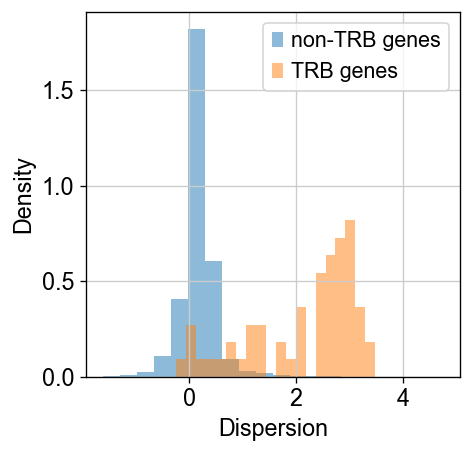

In [13]:
plt.hist(data=expr.var.loc[~expr.var.trb], x="dispersions", label="non-TRB genes", density=True, alpha=0.5, bins=20)
plt.hist(data=expr.var.loc[expr.var.trb], x="dispersions", label="TRB genes", density=True, alpha=0.5, bins=20)
plt.xlabel("Dispersion")
plt.ylabel("Density")
plt.legend()
plt.show()

In [14]:
sc.pp.scale(expr, max_value=10)

# Visualize clusters

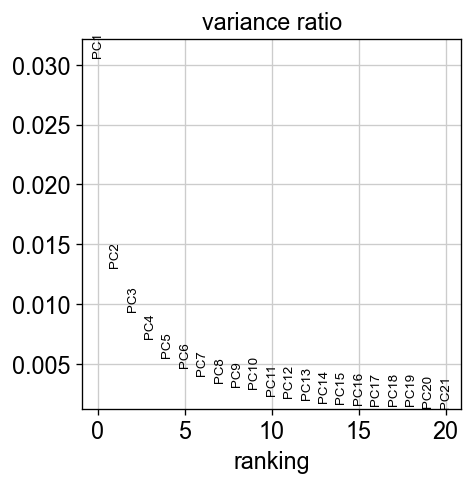

In [15]:
sc.tl.pca(expr)
sc.pl.pca_variance_ratio(expr, n_pcs=20)

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


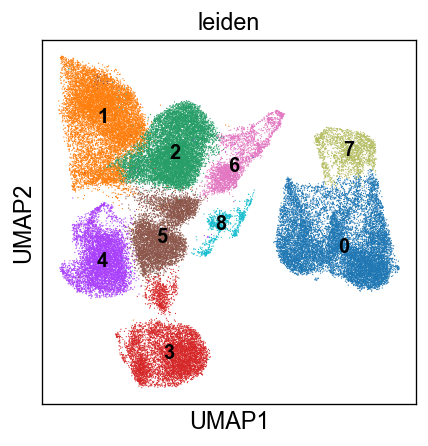

In [17]:
sc.pp.neighbors(expr, n_pcs=15)
sc.tl.leiden(expr, resolution=0.2)
sc.tl.umap(expr)
fig = sc.pl.umap(expr, color=['leiden'],
                legend_fontsize = 12,
                legend_loc = 'on data')

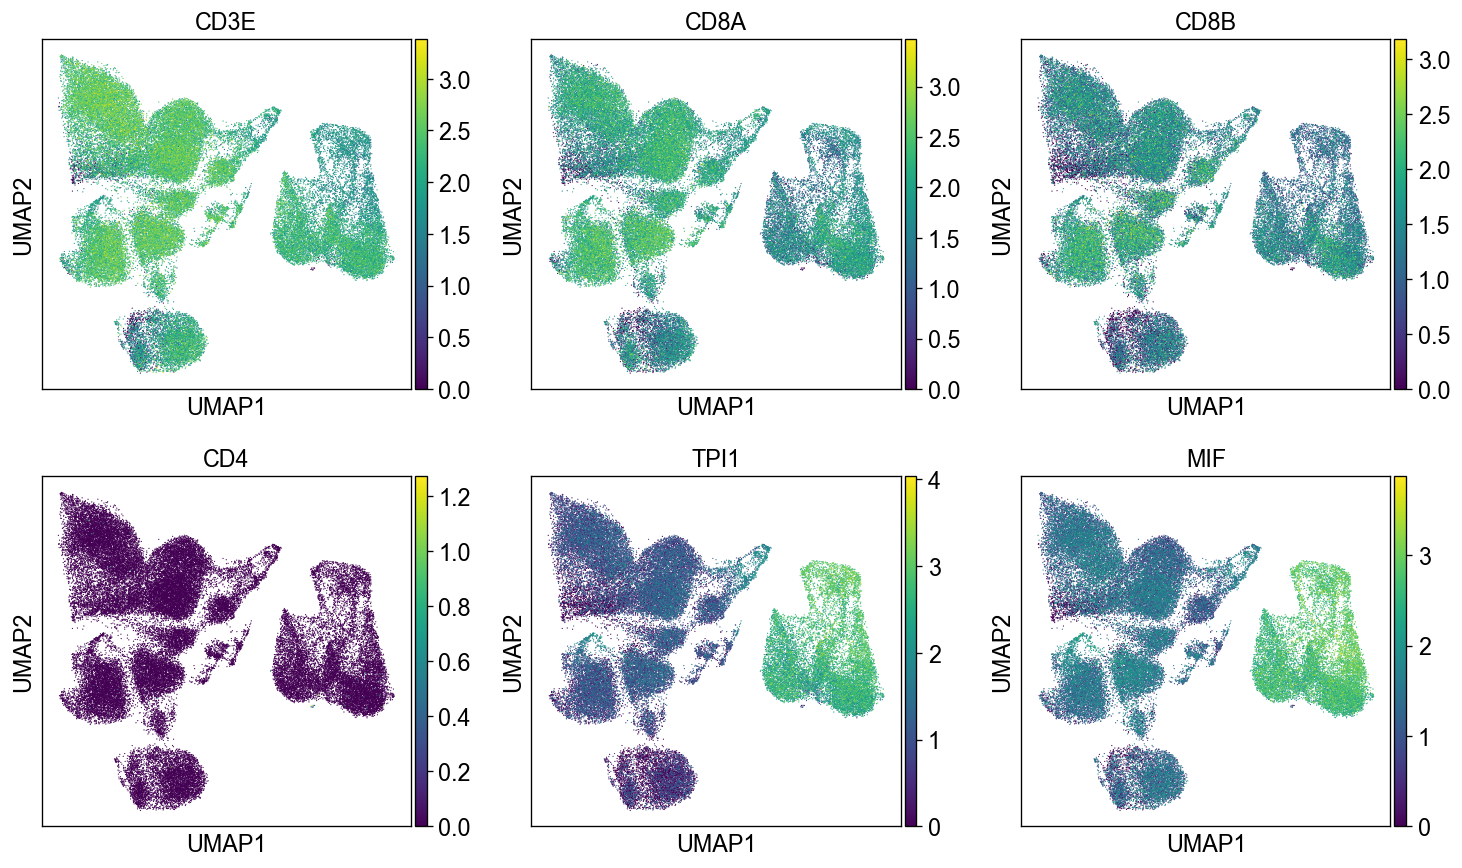

In [21]:
genes_to_plot = ["CD3E", "CD8A", "CD8B", "CD4", "TPI1", "MIF"] 
sc.pl.umap(expr, color=genes_to_plot, use_raw=True,
                sort_order=True, ncols=3, cmap='viridis')

In [22]:
#sc.pl.violin(expr, genes_to_plot,
#             jitter=0.4, multi_panel=True)

In [23]:
#sc.pl.stacked_violin(expr, genes_to_plot, groupby='leiden', swap_axes=True)
#plt.show()

In [24]:
# Single cell heatmap of feature expression

print(os.getcwd())
gene_md = "../GSE125881_raw.expMatrix.csv"

/Users/aburden/Desktop/TCR_Project_DESK/CAR_T_clonal_kinetics_legacy


# Match barcode data with metadata and visualized based on sample info

In [25]:
meta = pd.read_csv("../geo_metadata.csv")

id_to_timepoint_type = dict(zip(meta["id_in_expmatrix"].astype(str), meta["time_point_type"]))
id_to_disease_state = dict(zip(meta["id_in_expmatrix"].astype(str), meta["disease_state"]))
id_to_patient_id = dict(zip(meta["id_in_expmatrix"].astype(str), meta["patient_id"]))
meta.head(10)

#I couldnt get the new code to work so I manually edited the metadata

gsm_name  id_in_expmatrix patient_id disease_state time_point  \
0  GSM3583861                1      CLL-1           CLL         IP   
1  GSM3583862                2      CLL-1           CLL        d21   
2  GSM3583863                3      CLL-1           CLL        d38   
3  GSM3583864                4      CLL-1           CLL       d112   
4  GSM3583865                8      CLL-2           CLL         IP   
5  GSM3583866                9      CLL-2           CLL        d12   
6  GSM3583867               10      CLL-2           CLL        d29   
7  GSM3583868               11      CLL-2           CLL        d83   
8  GSM3583869               16      NHL-6           NHL         IP   
9  GSM3583870                5      NHL-6           NHL        d12   

  time_point_type     ID  Assay  Age Sex CD8_T_cell_selection      LD  \
0              IP  CLL-1    10x   61   M                  CD8  Cy/Flu   
1           Early  CLL-1    10x   61   M                  CD8  Cy/Flu   
2     Contraction  CLL-1    10x   61   M                  CD8  Cy/Flu   
3            Late  CLL-1    10x   61   M                  CD8  Cy/Flu   
4              IP  CLL-2    10x   53   F                  CD8  Cy/Flu   
5           Early  CLL-2    10x   53   F                  CD8  Cy/Flu   
6     Contraction  CLL-2    10x   53   F                  CD8  Cy/Flu   
7            Late  CLL-2    10x   53   F                  CD8  Cy/Flu   
8              IP  NHL-6  10x-I   64   M               CD8TCM  Cy/Flu   
9           Early  NHL-6  10x-I   64   M               CD8TCM  Cy/Flu   

  Cell_dose(EGFRt+cells/kg)  Neurotox  CRS Outcome DFS/PFS_Status  DFS/PFS_Day  
0                     2x105         0    0      CR     CR_Ongoing          947  
1                     2x105         0    0      CR     CR_Ongoing          947  
2                     2x105         0    0      CR     CR_Ongoing          947  
3                     2x105         0    0      CR     CR_Ongoing          947  
4                     2x106         3    2      CR     CR_Ongoing          764  
5                     2x106         3    2      CR     CR_Ongoing          764  
6                     2x106         3    2      CR     CR_Ongoing          764  
7                     2x106         3    2      CR     CR_Ongoing          764  
8                     2x106         3    4      CR    Progression          285  
9                     2x106         3    4      CR    Progression          285

In [26]:
expr.obs["sample_id"] = [barcode.split("-")[-1] for barcode in expr.obs.index]
expr.obs["disease_state"] = expr.obs["sample_id"].map(id_to_disease_state)
expr.obs["time_point_type"] = expr.obs["sample_id"].map(id_to_timepoint_type)
expr.obs["patient_id"] = expr.obs["sample_id"].map(id_to_patient_id)
expr.obs["patient_timepoint"] = expr.obs["patient_id"] + "-" + expr.obs["time_point_type"]
#expr.obs["outcome"] = expr.obs["patient_id"].map(dict(zip(meta["patient_id"], meta["Outcome"])))
expr.obs["status"] = expr.obs["patient_id"].map(dict(zip(meta["patient_id"], meta["DFS/PFS_Status"])))


/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


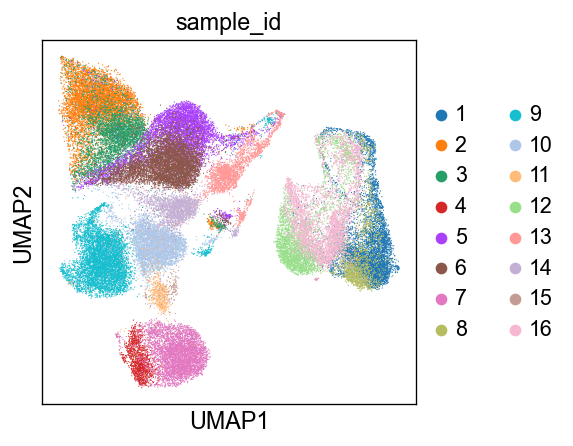

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


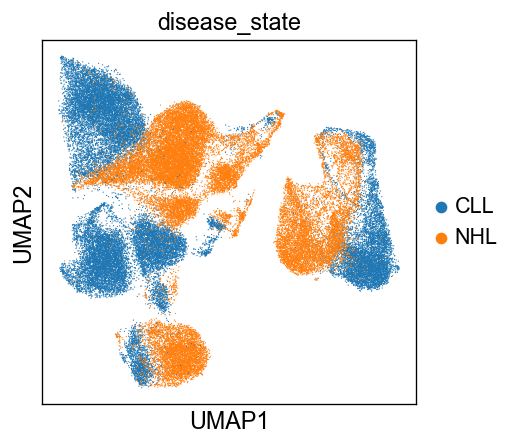

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


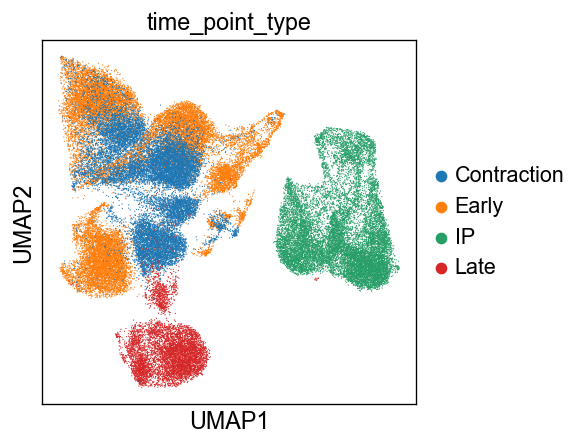

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


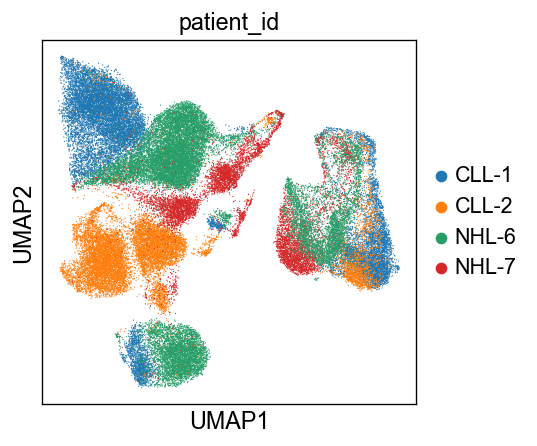

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


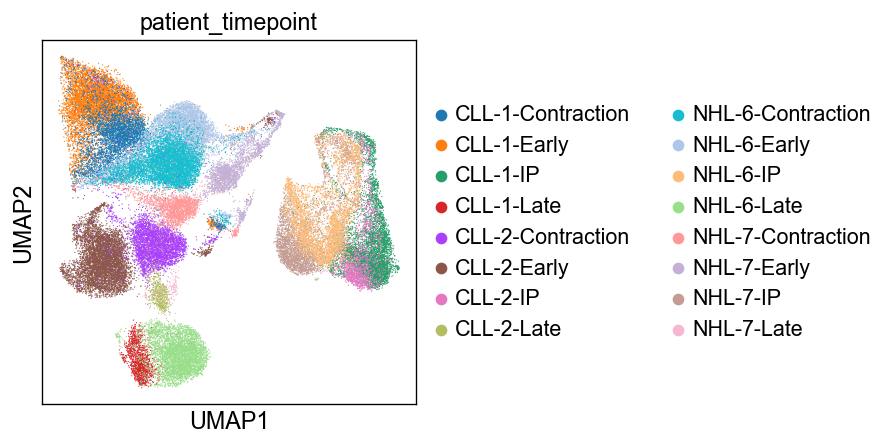

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


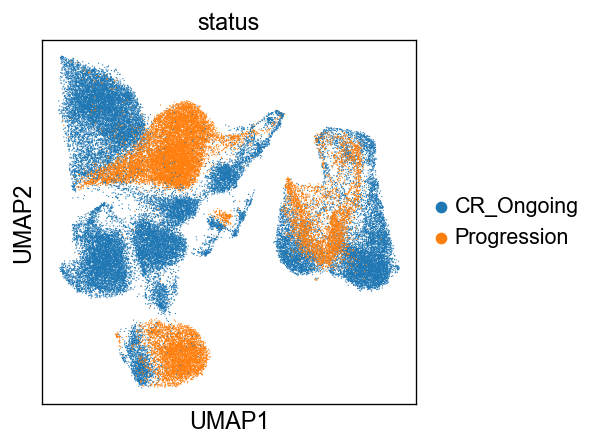

In [29]:
sc.pl.umap(expr, color="sample_id")
sc.pl.umap(expr, color="disease_state")
sc.pl.umap(expr, color="time_point_type")
sc.pl.umap(expr, color="patient_id")
sc.pl.umap(expr, color="patient_timepoint")
#sc.pl.umap(expr, color="Outcome")
sc.pl.umap(expr, color="status")

# Differential Expression & Heatmaps
* for a given patient how does gene expression change over time?
    * compare Early, Contraction, and Late to IP
    * do GSEA btwn E,C,L and IP
    
The below code is derived from: https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_05_dge.html

# T-test

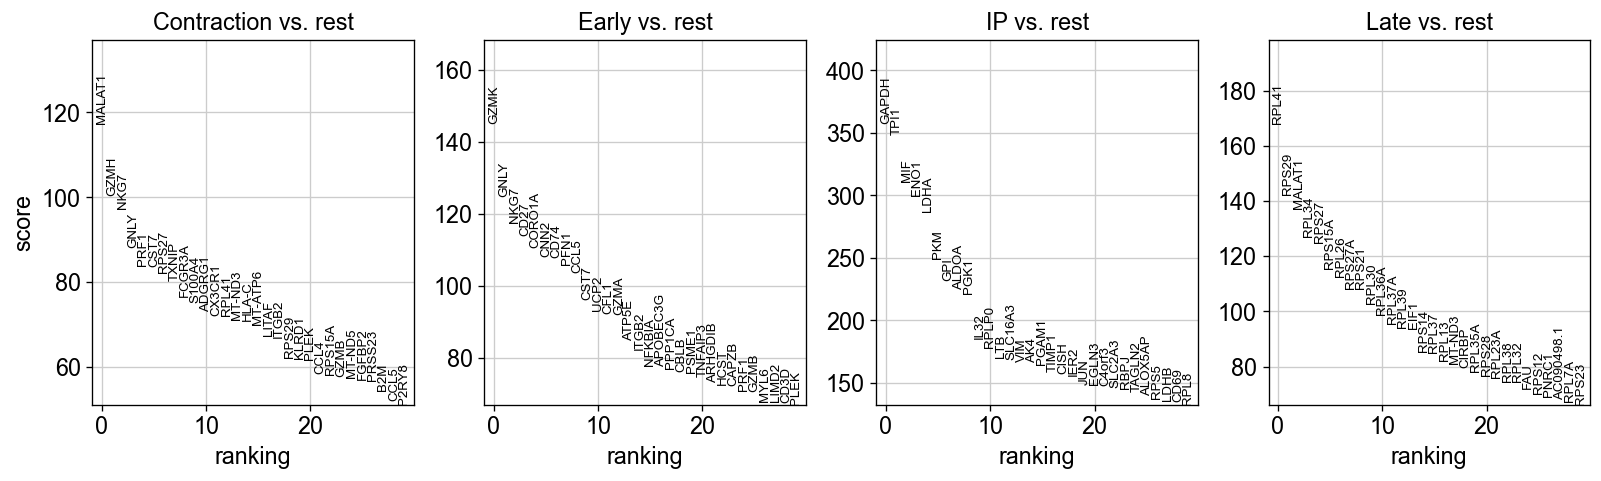

In [30]:
sc.tl.rank_genes_groups(expr, "time_point_type", method = 't-test', key_added = 't-test')
sc.pl.rank_genes_groups(expr, n_genes=30, sharey=False, key = 't-test')

In [31]:
#results are stored in the adata.uns['t-test'] slot
expr

AnnData object with n_obs × n_vars = 57122 × 20107
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'sample_id', 'disease_state', 'time_point_type', 'patient_id', 'patient_timepoint', 'status'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'trb', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'sample_id_colors', 'disease_state_colors', 'time_point_type_colors', 'patient_id_colors', 'patient_timepoint_colors', 'status_colors', 't-test'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# T-test overestimated_variance

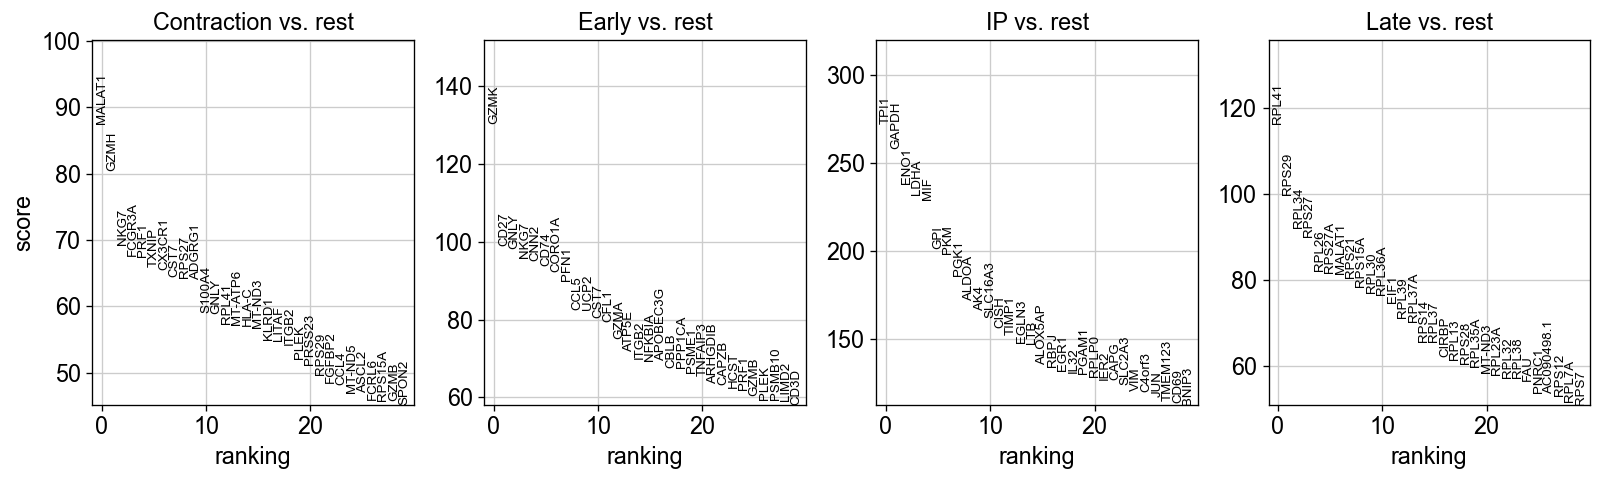

In [32]:
sc.tl.rank_genes_groups(expr, "time_point_type", method = 't-test_overestim_var', key_added ="t-test_ov")
sc.pl.rank_genes_groups(expr, n_genes=30, sharey=False, key = 't-test_ov')

# Wilcoxon rank-sum

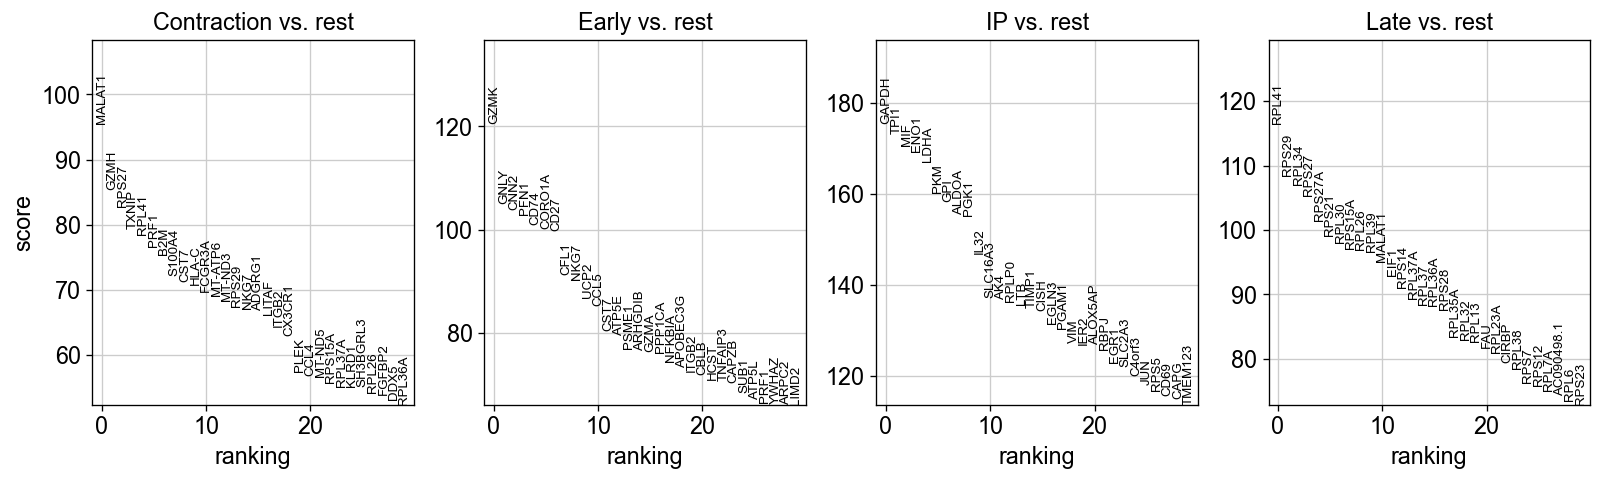

In [33]:
sc.tl.rank_genes_groups(expr, "time_point_type", method = 'wilcoxon', key_added = 'wilcoxon')
sc.pl.rank_genes_groups(expr, n_genes = 30, sharey=False, key = "wilcoxon")

# Logistic Regression Test

In [34]:
#sc.tl.rank_genes_groups(expr, 'time_point_type', method = 'logreg', key_added = 'logreg')
#sc.pl.genes_groups(expr, n_genes = 30, sharey=False, key = 'logreg')

# Compare Genes

In [35]:
expr

AnnData object with n_obs × n_vars = 57122 × 20107
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'sample_id', 'disease_state', 'time_point_type', 'patient_id', 'patient_timepoint', 'status'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'trb', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'sample_id_colors', 'disease_state_colors', 'time_point_type_colors', 'patient_id_colors', 'patient_timepoint_colors', 'status_colors', 't-test', 't-test_ov', 'wilcoxon'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

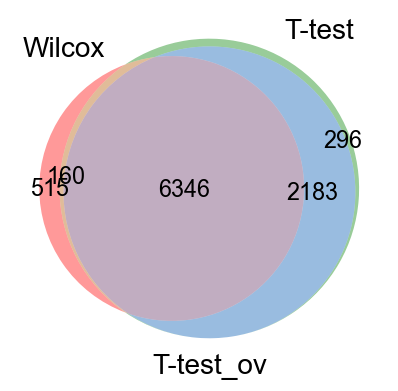

In [40]:
#compare culster1 genes, only stores top 100 by default

wc = sc.get.rank_genes_groups_df(expr, group='IP', key = 'wilcoxon', pval_cutoff=0.01, log2fc_min=0)['names']
tt = sc.get.rank_genes_groups_df(expr, group='IP', key = 't-test', pval_cutoff=0.01, log2fc_min=0)['names']
tt_ov = sc.get.rank_genes_groups_df(expr, group='IP', key = 't-test_ov', pval_cutoff=0.01, log2fc_min=0)['names']

from matplotlib_venn import venn3 #make sure matplotlib_venn is installed separate from matplotlib

venn3([set(wc),set(tt),set(tt_ov)], ('Wilcox', 'T-test', 'T-test_ov'))
plt.show()

#KeyError: "None of [Index(['0'], dtype='object')] are in the [columns]"

# Visualization

In [41]:
expr.var

mt  n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
RP11-34P13.7   False                 38     0.000611              99.938874   
FO538757.3     False                 55     0.000885              99.911529   
FO538757.2     False              10715     0.209018              82.764167   
AP006222.2     False                469     0.007657              99.245580   
RP4-669L17.10  False                 77     0.001255              99.876140   
...              ...                ...          ...                    ...   
AL592183.1     False                989     0.016311              98.409124   
AC007325.4     False                  6     0.000097              99.990349   
AL354822.1     False                215     0.003491              99.654157   
AC004556.1     False                786     0.012820              98.735664   
AC240274.1     False                 84     0.001351              99.864880   

               total_counts  n_cells  highly_variable     means  dispersions  \
RP11-34P13.7           38.0       38            False  0.000619     0.430941   
FO538757.3             55.0       55            False  0.000644    -0.125891   
FO538757.2          12994.0    10715            False  0.171796     0.247772   
AP006222.2            476.0      469            False  0.006566     0.066244   
RP4-669L17.10          78.0       77            False  0.001100     0.439406   
...                     ...      ...              ...       ...          ...   
AL592183.1           1014.0      989            False  0.014320     0.181777   
AC007325.4              6.0        6            False  0.000038    -0.133470   
AL354822.1            217.0      215            False  0.003037     0.424757   
AC004556.1            797.0      786            False  0.011323     0.353681   
AC240274.1             84.0       84            False  0.001413     0.244243   

               dispersions_norm    trb      mean       std  
RP11-34P13.7           0.867103  False  0.000398  0.017694  
FO538757.3            -0.841283  False  0.000468  0.016660  
FO538757.2             0.305134  False  0.120980  0.283590  
AP006222.2            -0.251805  False  0.004568  0.055311  
RP4-669L17.10          0.893074  False  0.000705  0.023560  
...                         ...    ...       ...       ...  
AL592183.1             0.102656  False  0.009826  0.082005  
AC007325.4            -0.864534  False  0.000028  0.003937  
AL354822.1             0.848131  False  0.001988  0.038440  
AC004556.1             0.630065  False  0.007522  0.074090  
AC240274.1             0.294306  False  0.000933  0.026635  

[20107 rows x 13 columns]

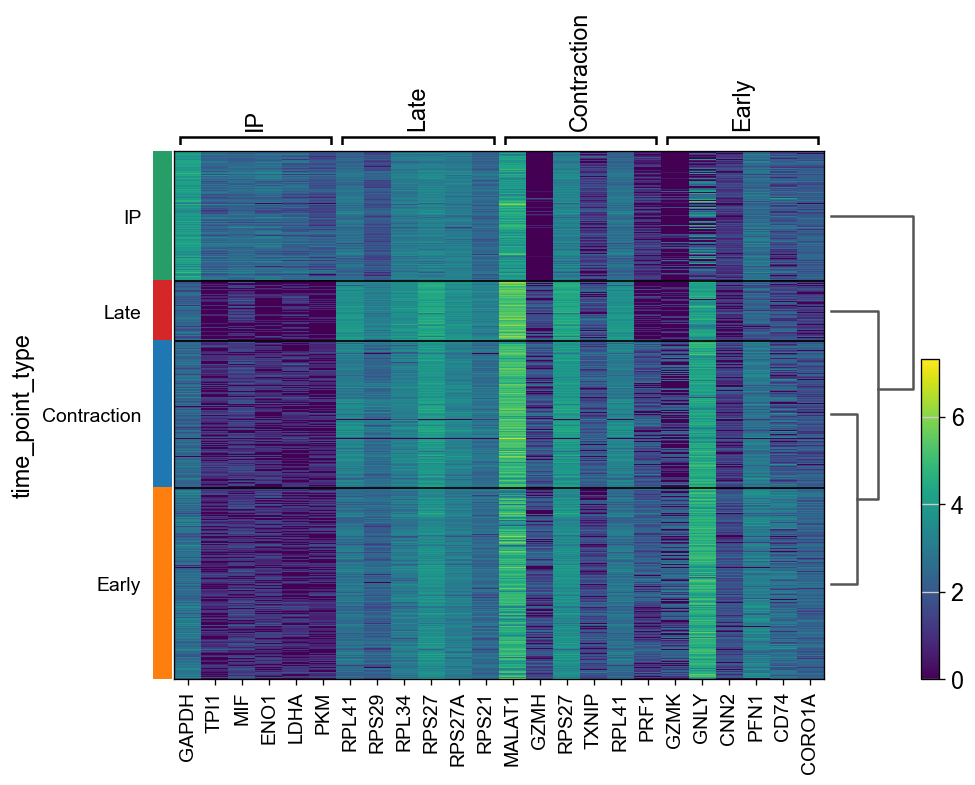

In [44]:
sc.pl.rank_genes_groups_heatmap(expr, n_genes = 6, key="wilcoxon", groupby="time_point_type", show_gene_labels=True, swap_axes=False)

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


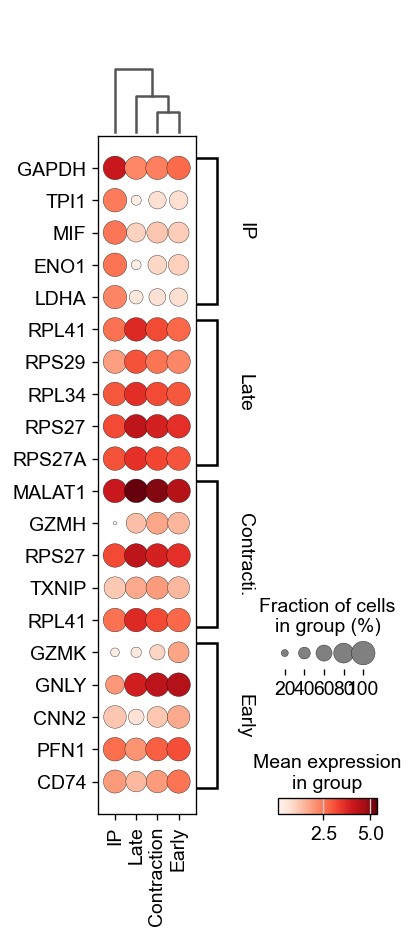

In [45]:
sc.pl.rank_genes_groups_dotplot(expr, n_genes=5, key='wilcoxon', groupby='time_point_type', swap_axes=True)

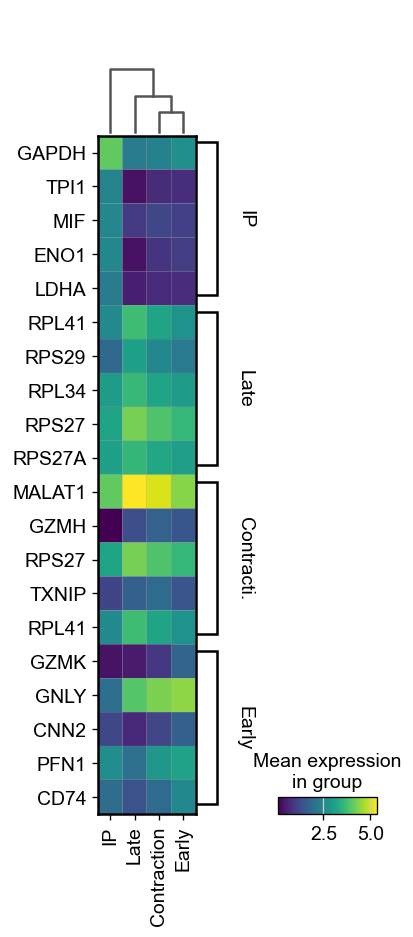

In [46]:
sc.pl.rank_genes_groups_matrixplot(expr, n_genes=5, key='wilcoxon', groupby="time_point_type", swap_axes=True)

# Compare Specific Clusters

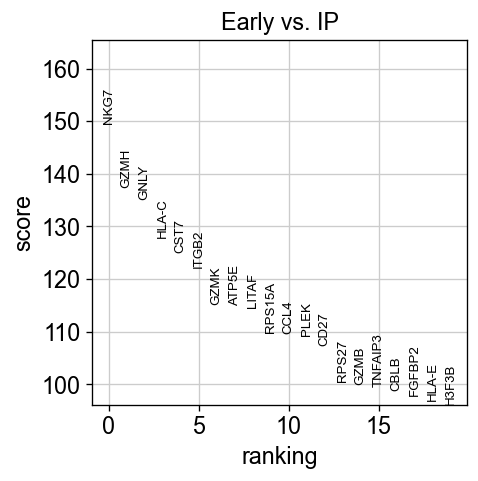

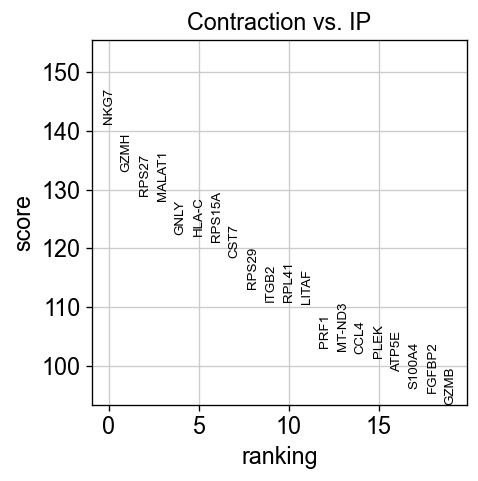

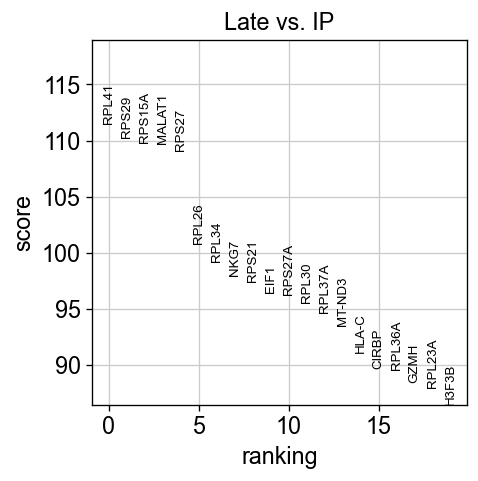

In [48]:
sc.tl.rank_genes_groups(expr, "time_point_type", groups=['Early'], reference = 'IP', method = 'wilcoxon')
sc.pl.rank_genes_groups(expr, groups=['Early'], n_genes=20)

sc.tl.rank_genes_groups(expr, "time_point_type", groups=['Contraction'], reference = 'IP', method = 'wilcoxon')
sc.pl.rank_genes_groups(expr, groups=['Contraction'], n_genes=20)

sc.tl.rank_genes_groups(expr, "time_point_type", groups=['Late'], reference = 'IP', method = 'wilcoxon')
sc.pl.rank_genes_groups(expr, groups=['Late'], n_genes=20)



/Users/andrewburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


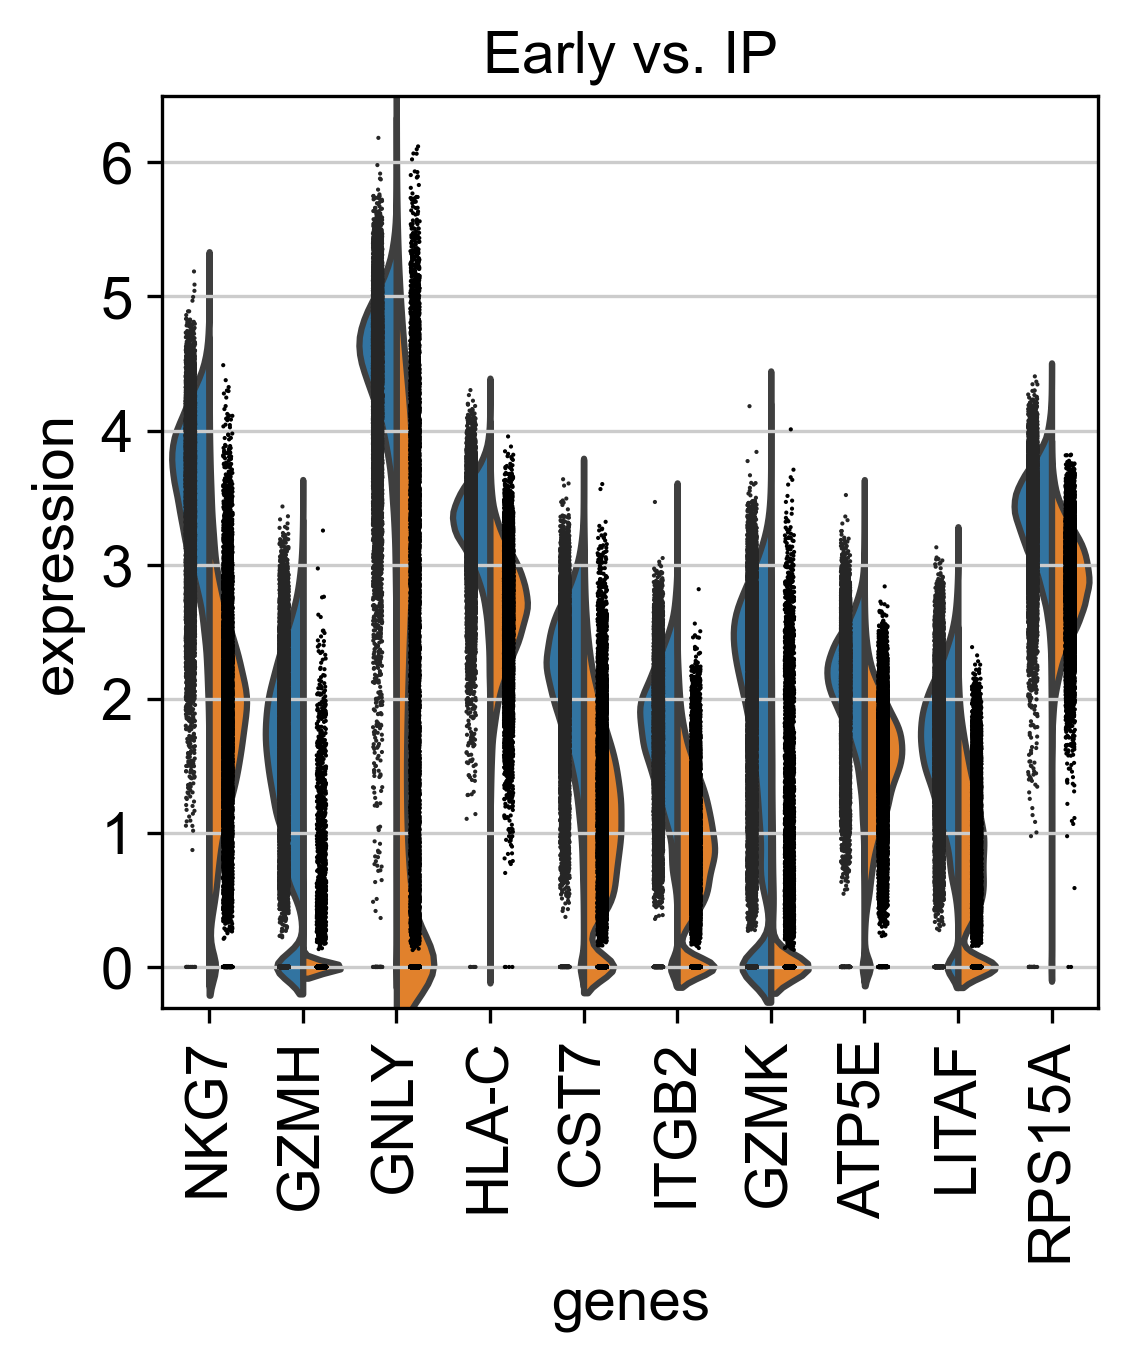

In [69]:
sc.pl.rank_genes_groups_violin(expr, groups='Early', n_genes = 10, jitter=True)

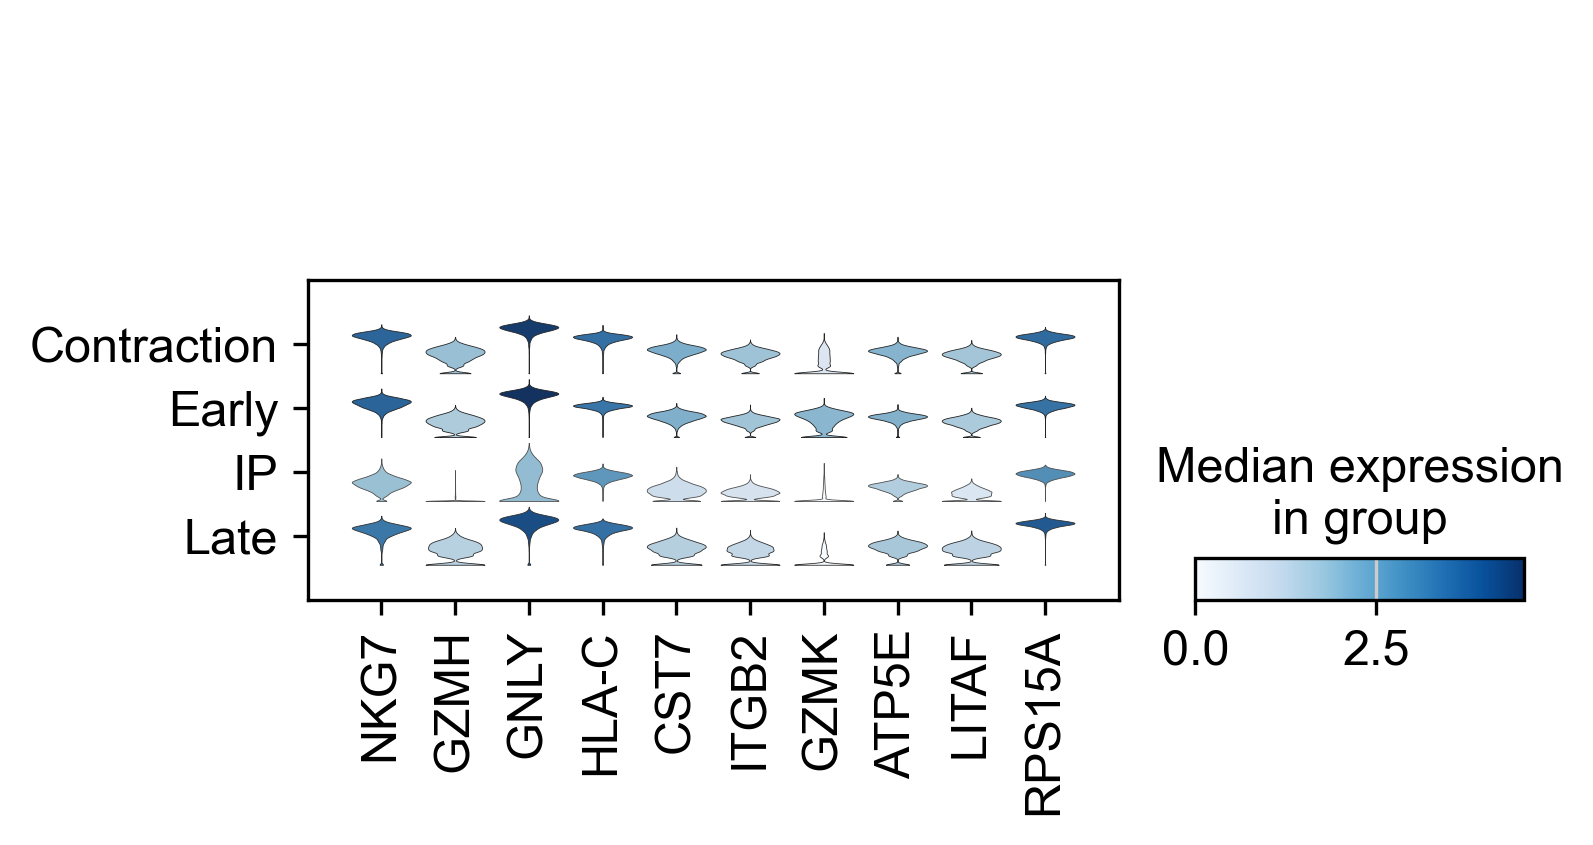

In [72]:
#plot the same genes as violins across all the datasets

#convert numpy.recarray to list
mynames = [x[0] for x in expr.uns['rank_genes_groups']['names'][:10]]
sc.pl.stacked_violin(expr, mynames, groupby = "time_point_type")

# Differential expression across conditions

In [53]:
subset = expr[expr.obs['leiden'] == '3',:] #I have NO idea what this number refers to
subset.obs['status'].value_counts()

Progression    4302
CR_Ongoing     2061
Name: status, dtype: int64

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


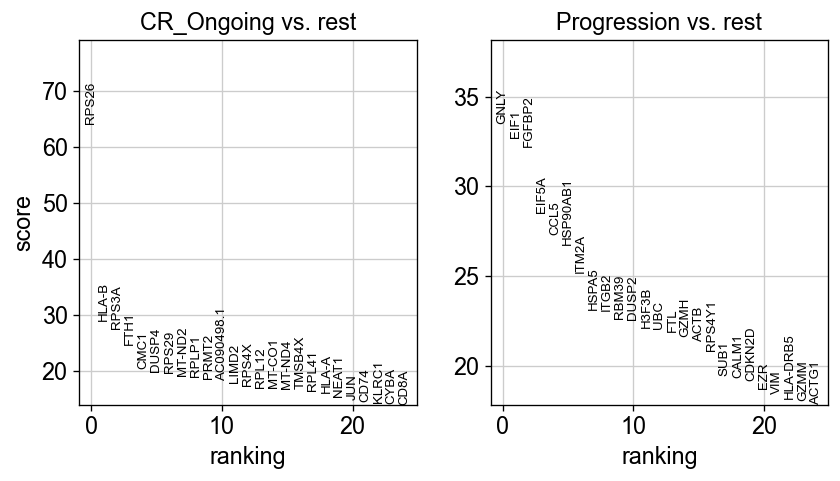

In [54]:
#ranking genes
sc.tl.rank_genes_groups(subset, "status", method = 'wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(subset, n_genes=25, sharey=False, key='wilcoxon')

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


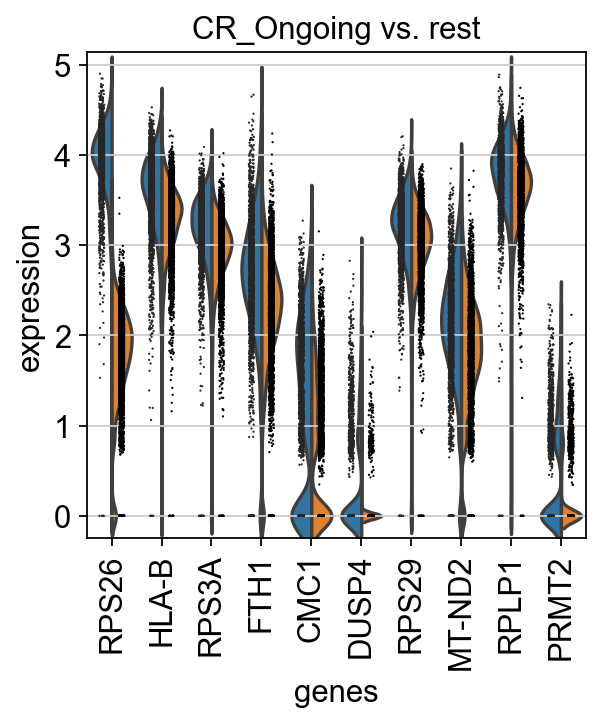

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


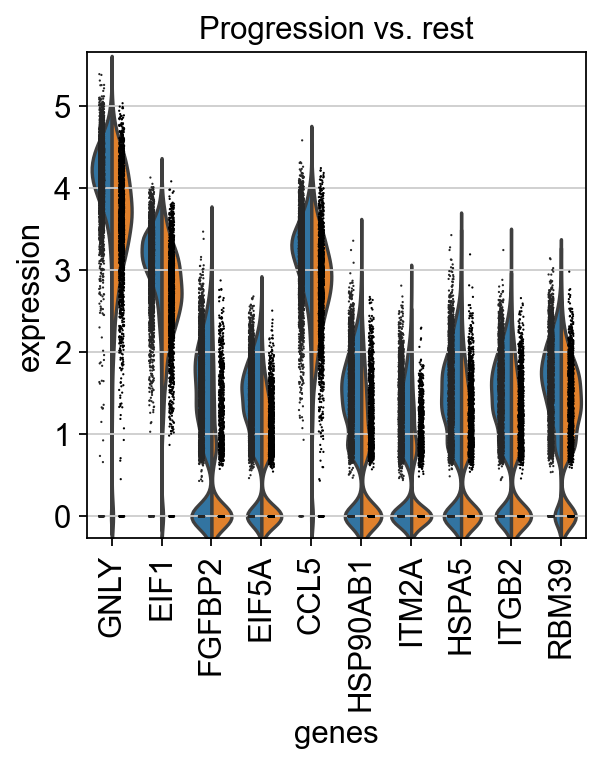

In [58]:
sc.pl.rank_genes_groups_violin(subset, n_genes=10, key="wilcoxon", jitter = True)

In [60]:
genes1 = sc.get.rank_genes_groups_df(subset, group='CR_Ongoing', key='wilcoxon')['names'][:5]
genes2 = sc.get.rank_genes_groups_df(subset, group='Progression', key='wilcoxon')['names'][:5]
genes = genes1.tolist() +  genes2.tolist() 
df = sc.get.obs_df(expr, genes + ['time_point_type','status'], use_raw=False)
df2 = df.melt(id_vars=["time_point_type",'status'], value_vars=genes)

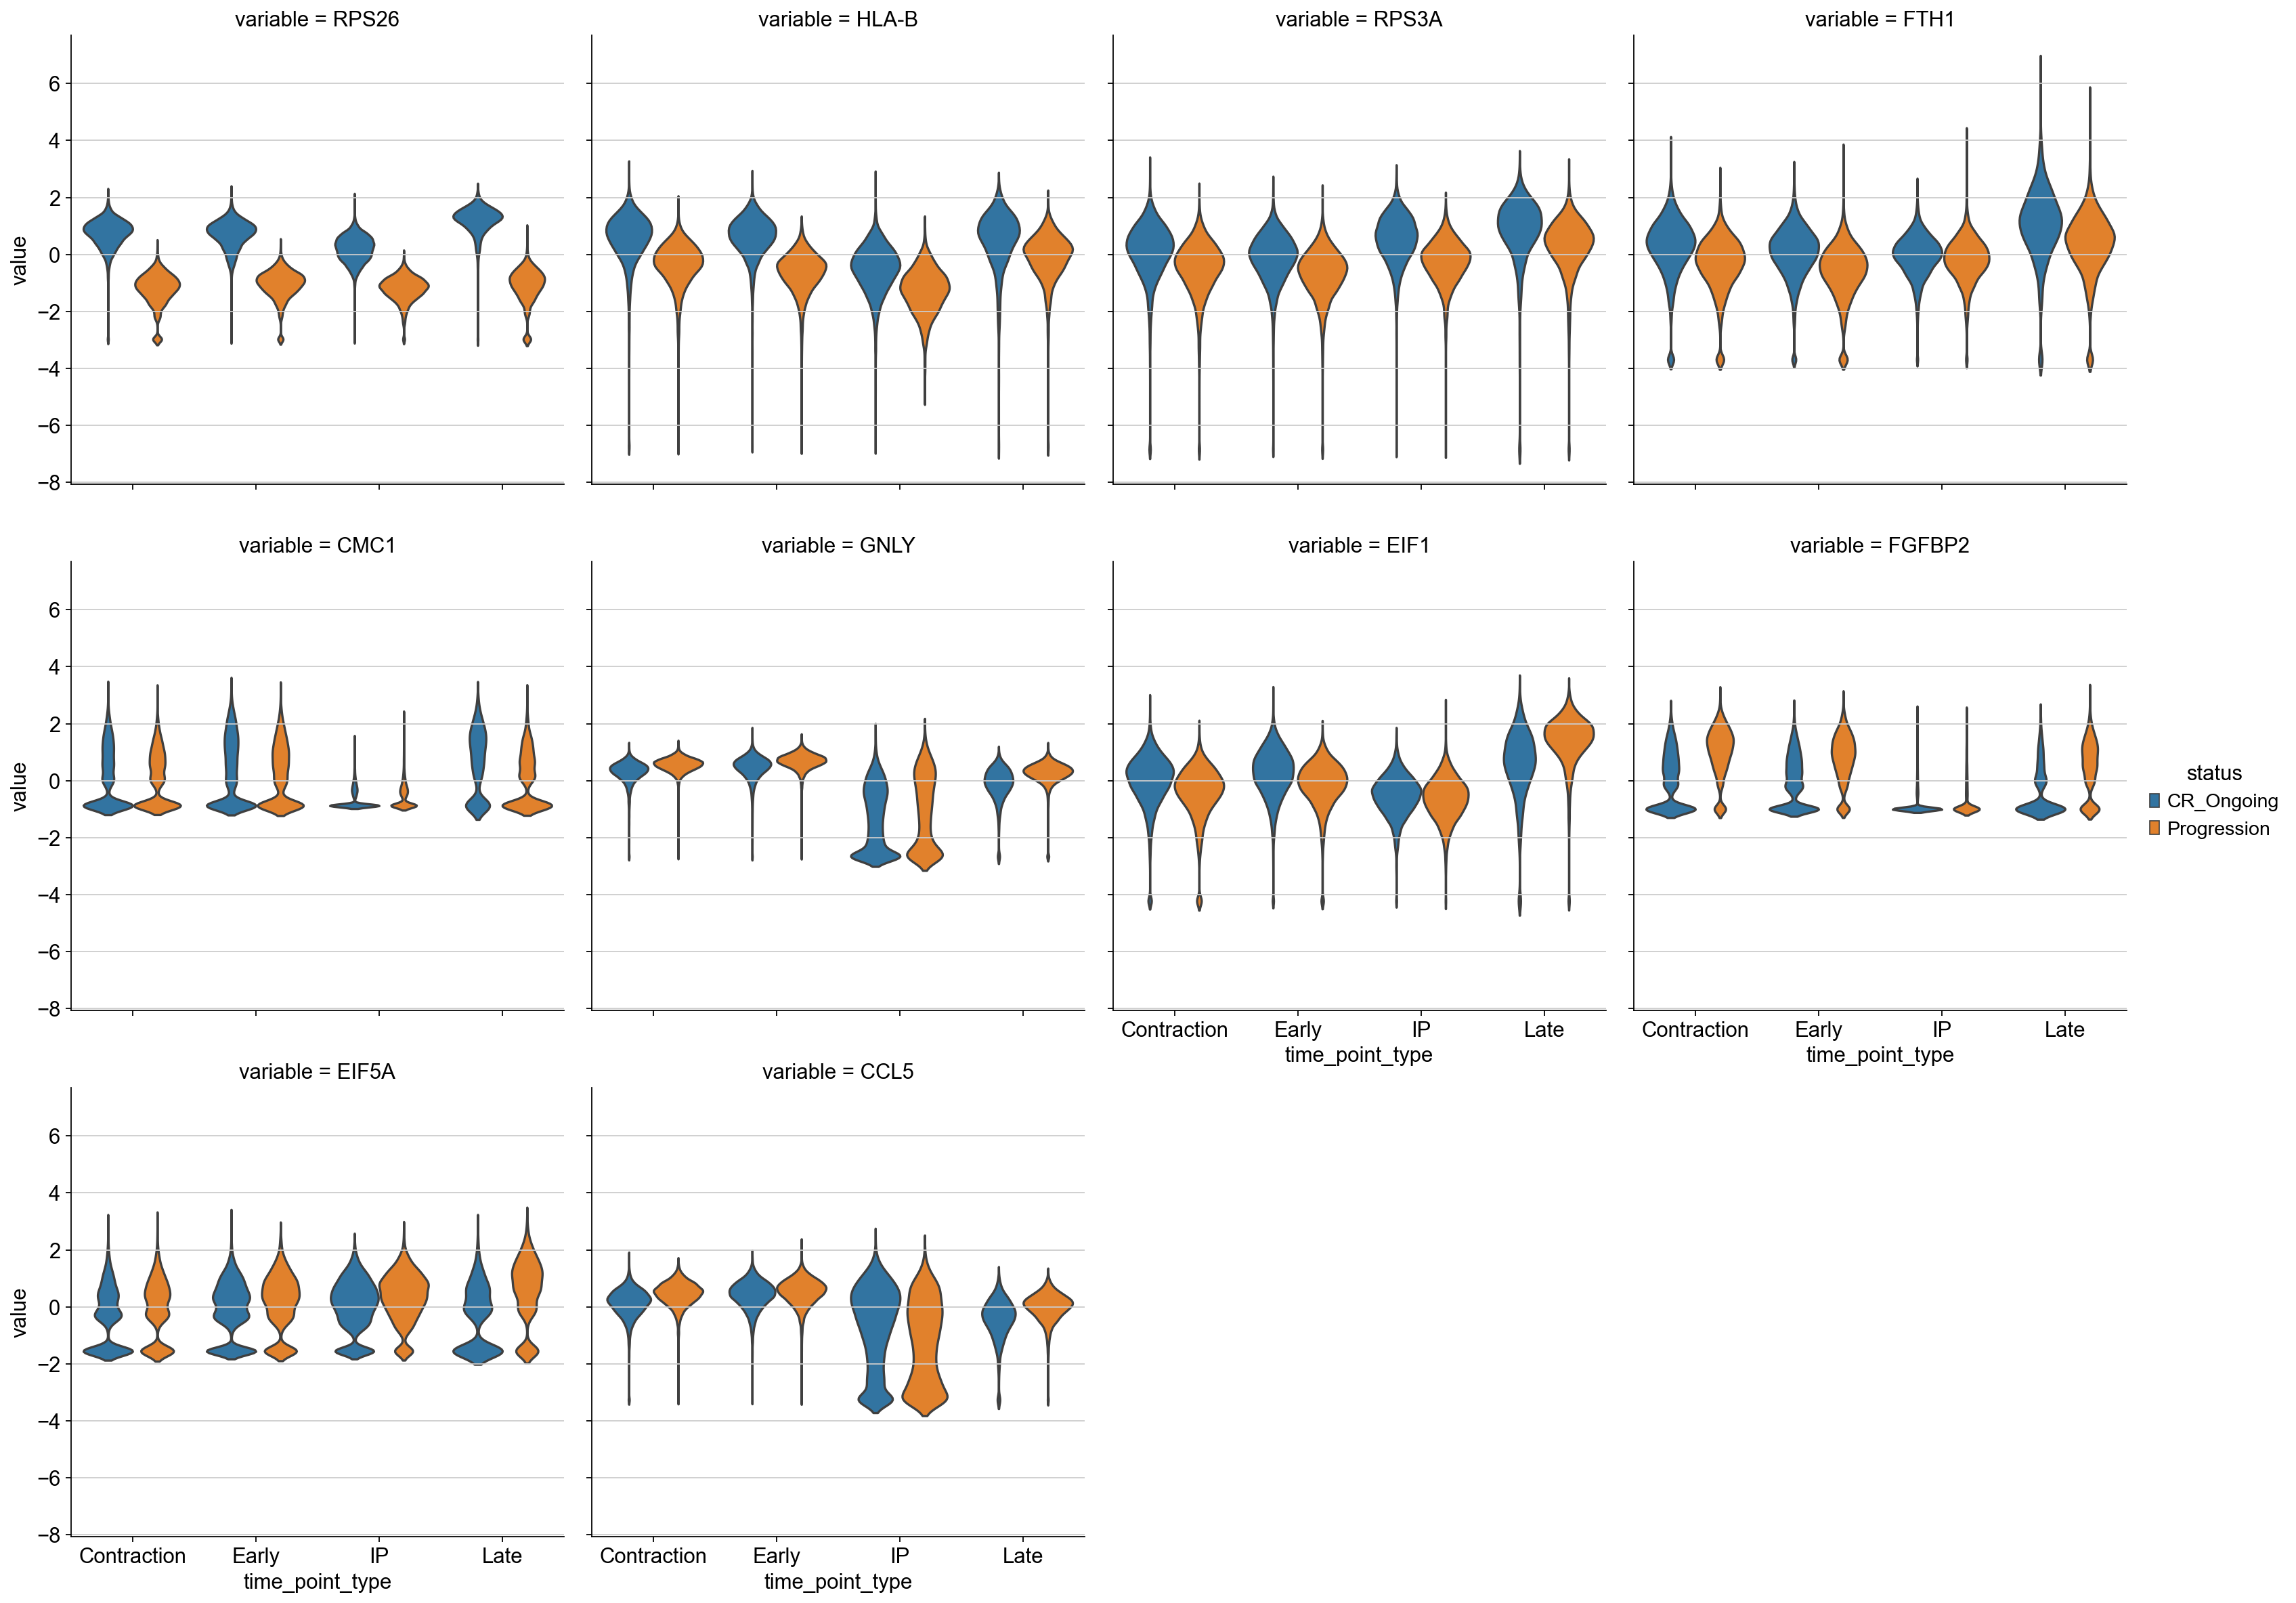

In [64]:
sns.catplot(x = "time_point_type", y = "value", hue = "status", kind = 'violin', 
               col = "variable", data = df2, col_wrap=4, inner=None)

# Patient Batch Effect
When we are testing for Covid vs Control we are running a DGE test for 3 vs 3 individuals. That will be very sensitive to sample differences unless we find a way to control for it. So first, lets check how the top DGEs are expressed across the individuals:


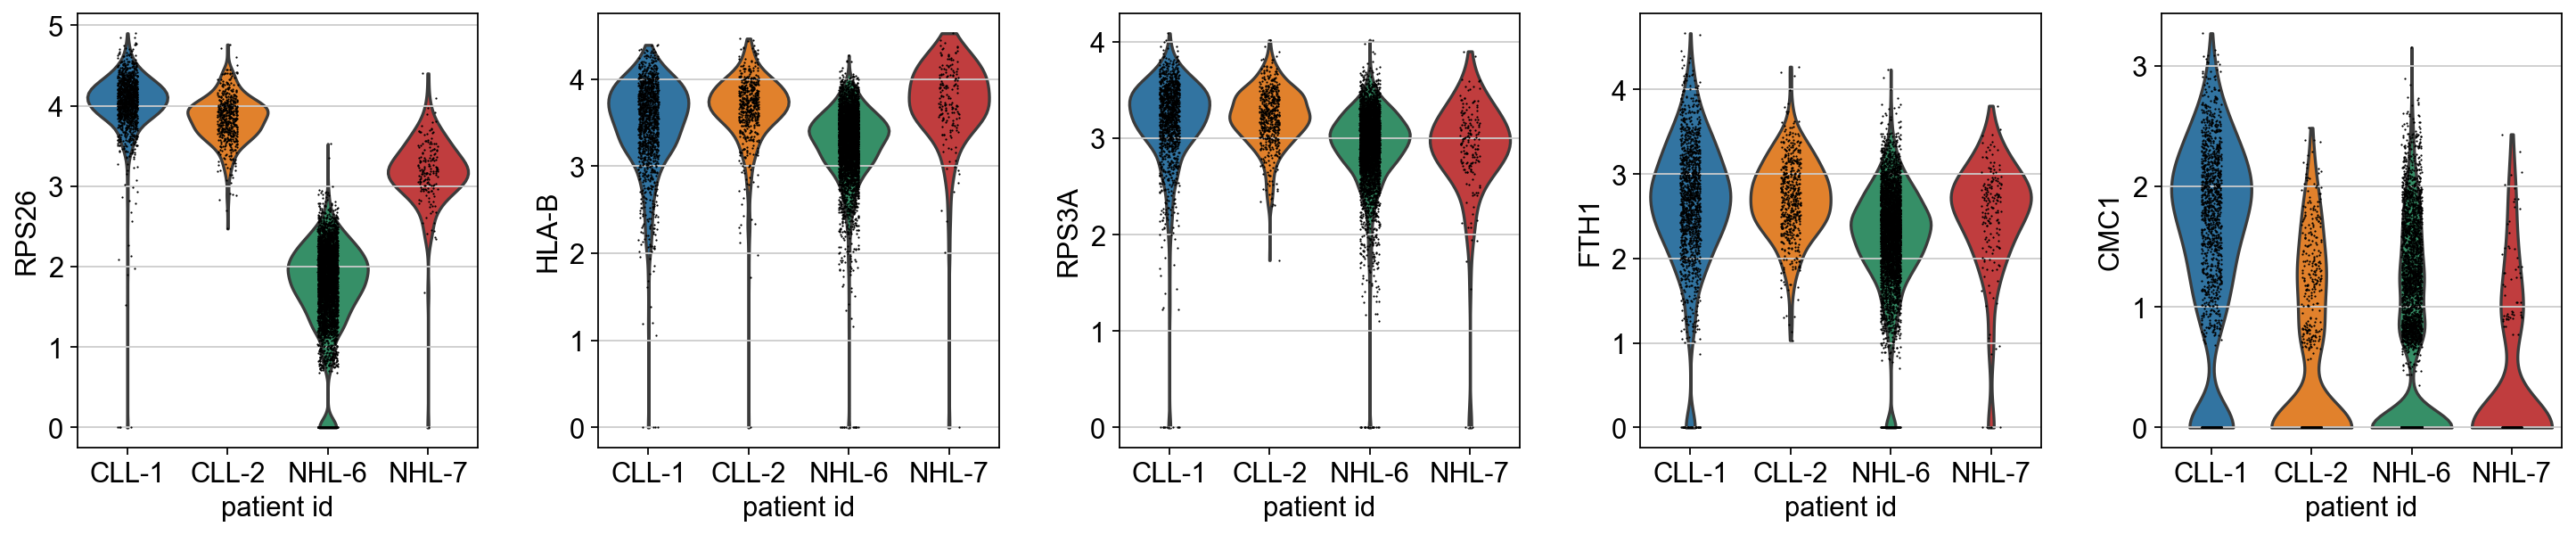

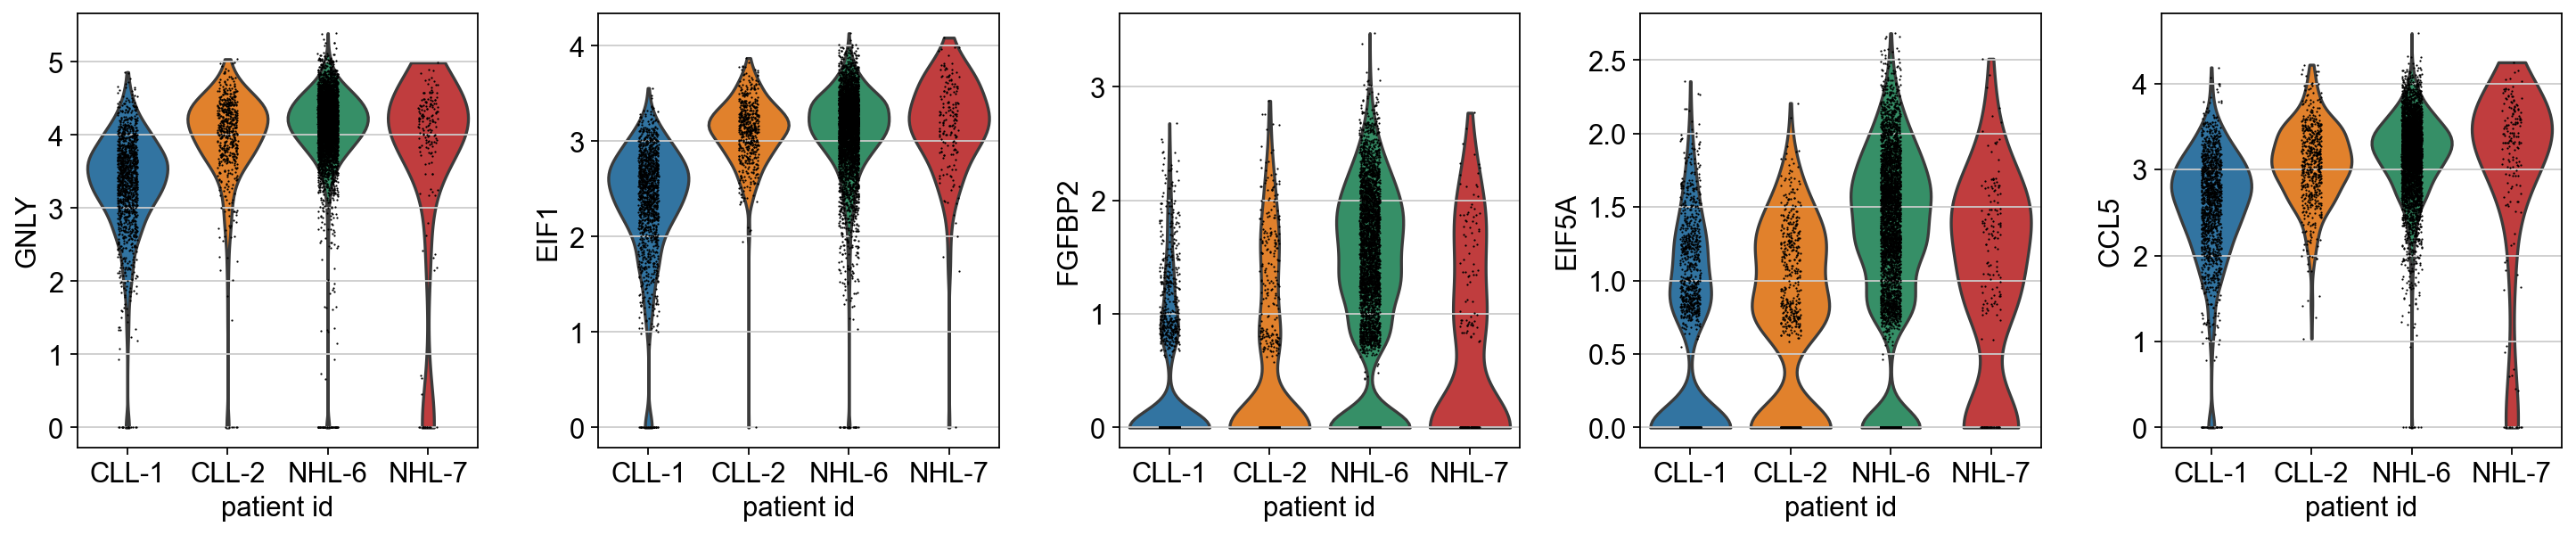

In [70]:
genes1 = sc.get.rank_genes_groups_df(subset, group='CR_Ongoing', key='wilcoxon')['names'][:5]
genes2 = sc.get.rank_genes_groups_df(subset, group='Progression', key='wilcoxon')['names'][:5]
genes = genes1.tolist() +  genes2.tolist() 

sc.pl.violin(subset, genes1, groupby='patient_id')
sc.pl.violin(subset, genes2, groupby='patient_id')

As you can see, many of the genes detected as DGE in Covid are unique to one or 2 patients.

We can examine more genes with a DotPlot:

We can also plot the top 'CR_Ongoing' and top 'Progression' genes as a dotplot:

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


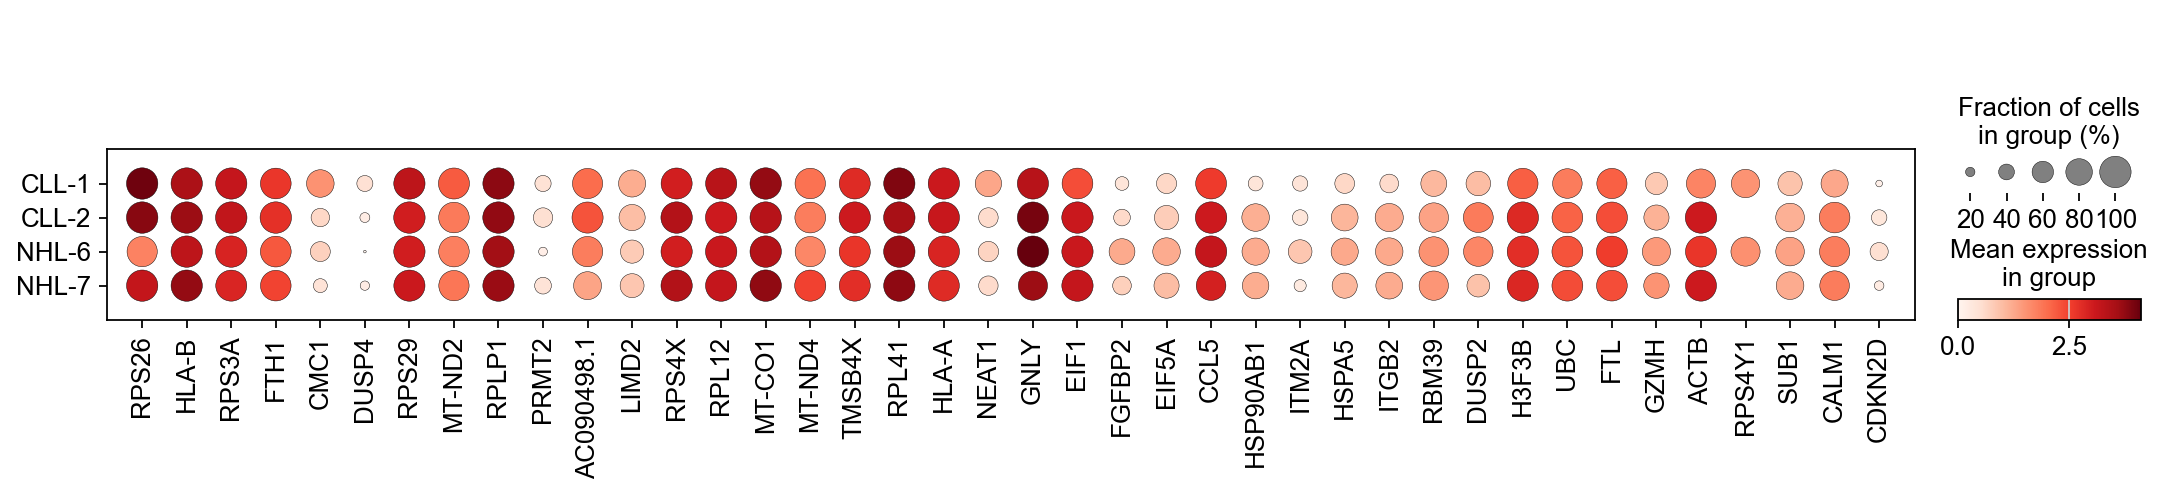

In [71]:
genes1 = sc.get.rank_genes_groups_df(subset, group='CR_Ongoing', key='wilcoxon')['names'][:20]
genes2 = sc.get.rank_genes_groups_df(subset, group='Progression', key='wilcoxon')['names'][:20]
genes = genes1.tolist() +  genes2.tolist() 

sc.pl.dotplot(subset,genes, groupby='patient_id')

In [72]:
subset.obs['patient_id'].value_counts()

NHL-6    4302
CLL-1    1342
CLL-2     548
NHL-7     171
Name: patient_id, dtype: int64

# Subsample
So one obvious thing to consider is an equal amount of cells per individual so that the DGE results are not dominated by a single sample.

So we will downsample to an equal number of cells per sample.

In [84]:
# Define Variable === Saver yourself some time :)

var_type = 'status' #what do you want to separate by?
var_1 = 'patient_id' #what do you want to standardize across?
group1 = 'CR_Ongoing'
group2 = 'Progression'
method = 'wilcoxon'

In [78]:
subset.obs['patient_id'].value_counts()

NHL-6    4302
CLL-1    1342
CLL-2     548
NHL-7     171
Name: patient_id, dtype: int64

In [79]:
#This will standardize the number of cells for DGE analysis
target_cells = 150

tmp = [subset[subset.obs[var1] == s] for s in subset.obs[var1].cat.categories]

for dat in tmp:
    if dat.n_obs > target_cells:
         sc.pp.subsample(dat, n_obs=target_cells)

subset_sub = tmp[0].concatenate(*tmp[1:])

subset_sub.obs[var1].value_counts()

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. 

CLL-1    150
CLL-2    150
NHL-6    150
NHL-7    150
Name: patient_id, dtype: int64

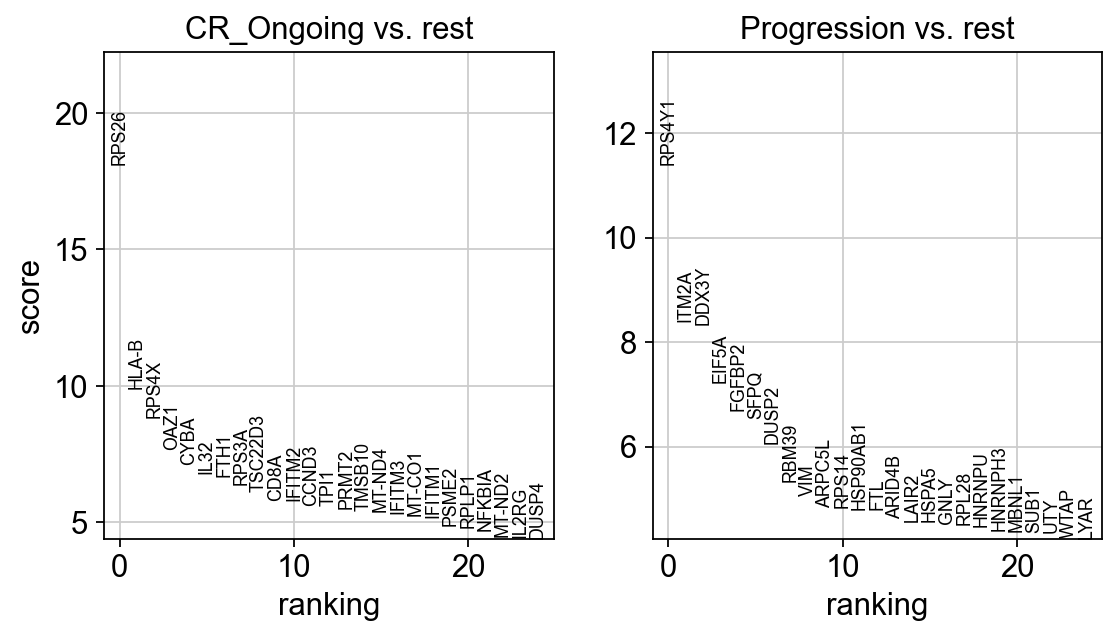

In [82]:
sc.tl.rank_genes_groups(subset_sub, var_type, method=method, key_added = method)
sc.pl.rank_genes_groups(subset_sub, n_genes=25, sharey=False, key=method)

/Users/aburden/miniconda3/envs/scRNA/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


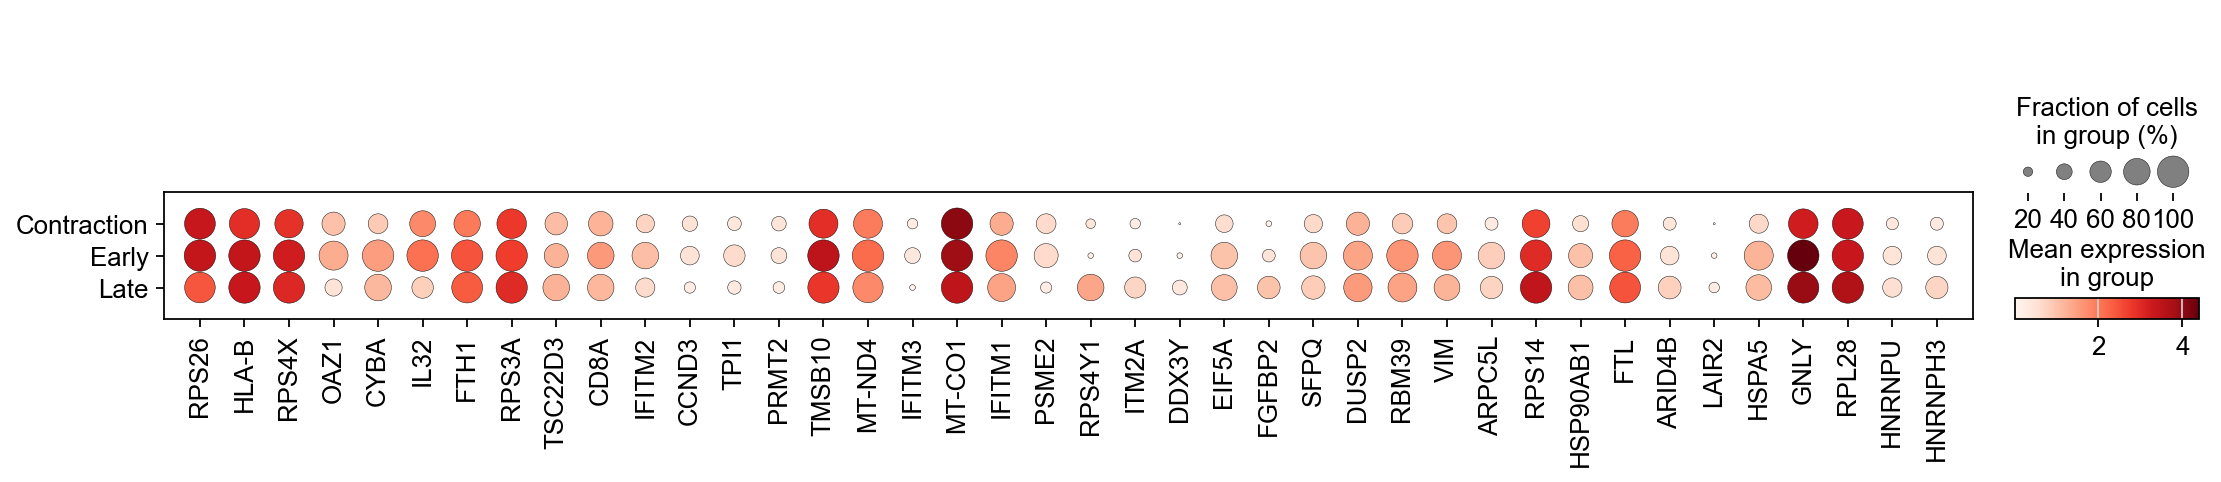

In [87]:
genes1 = sc.get.rank_genes_groups_df(subset_sub, group=group1, key=method)['names'][:20]
genes2 = sc.get.rank_genes_groups_df(subset_sub, group=group2, key=method)['names'][:20]
genes = genes1.tolist() +  genes2.tolist() 

sc.pl.dotplot(subset,genes, groupby='time_point_type')


# Gene Set Analysis
Hypergeometric enrichment test

Having a defined list of differentially expressed genes, you can now look for their combined function using hypergeometric test:

In [88]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(organism='Human')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'Diabetes_Perturbations_GEO_2022', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease

In [89]:
#get the significant DEGs
glist = sc.get.rank_genes_groups_df(subset_sub, group='Progression', 
                                    key=method, log2fc_min=0.25, 
                                    pval_cutoff=0.05)['names'].squeeze().str.strip().tolist()
print(len(glist))

46


In [90]:
enr_res = gseapy.enrichr(gene_list=glist,
                     organism='Human',
                     gene_sets='GO_Biological_Process_2018',
                     cutoff = 0.5)

In [92]:
enr_res.results.head(20)

Gene_set  \
0   GO_Biological_Process_2018   
1   GO_Biological_Process_2018   
2   GO_Biological_Process_2018   
3   GO_Biological_Process_2018   
4   GO_Biological_Process_2018   
5   GO_Biological_Process_2018   
6   GO_Biological_Process_2018   
7   GO_Biological_Process_2018   
8   GO_Biological_Process_2018   
9   GO_Biological_Process_2018   
10  GO_Biological_Process_2018   
11  GO_Biological_Process_2018   
12  GO_Biological_Process_2018   
13  GO_Biological_Process_2018   
14  GO_Biological_Process_2018   
15  GO_Biological_Process_2018   
16  GO_Biological_Process_2018   
17  GO_Biological_Process_2018   
18  GO_Biological_Process_2018   
19  GO_Biological_Process_2018   

                                                 Term Overlap       P-value  \
0                        mRNA processing (GO:0006397)  10/283  7.141080e-10   
1   RNA splicing, via transesterification reaction...   9/236  2.869257e-09   
2         mRNA splicing, via spliceosome (GO:0000398)   9/261  6.912022e-09   
3                         RNA processing (GO:0006396)   8/193  1.239628e-08   
4                  RNA metabolic process (GO:0016070)   7/191  2.534923e-07   
5                        gene expression (GO:0010467)   8/411  3.912984e-06   
6   regulation of mRNA splicing, via spliceosome (...    4/60  1.086678e-05   
7   regulation of alternative mRNA splicing, via s...    3/39  9.819154e-05   
8                           RNA splicing (GO:0008380)   4/106  1.024830e-04   
9   protein localization to cytoplasmic stress gra...     2/7  1.078816e-04   
10  maintenance of protein location in nucleus (GO...    2/15  5.331252e-04   
11  positive regulation of DNA-templated transcrip...    2/16  6.083945e-04   
12    positive regulation of translation (GO:0045727)    3/78  7.677085e-04   
13  maintenance of protein localization in organel...    2/18  7.734351e-04   
14        nucleic acid metabolic process (GO:0090304)    3/80  8.264465e-04   
15  Arp2/3 complex-mediated actin nucleation (GO:0...    2/20  9.576676e-04   
16                      actin nucleation (GO:0045010)    2/24  1.383020e-03   
17                      ncRNA processing (GO:0034470)   4/227  1.815257e-03   
18  nuclear-transcribed mRNA catabolic process, no...   3/112  2.177982e-03   
19  positive regulation of intrinsic apoptotic sig...    2/33  2.611196e-03   

    Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0       3.563399e-07            0                     0   20.025438   
1       7.158796e-07            0                     0   21.138588   
2       1.149700e-06            0                     0   19.017375   
3       1.546436e-06            0                     0   22.496728   
4       2.529853e-05            0                     0   19.285117   
5       3.254298e-04            0                     0   10.213400   
6       7.746461e-04            0                     0   33.840136   
7       5.383292e-03            0                     0   38.600775   
8       5.383292e-03            0                     0   18.535948   
9       5.383292e-03            0                     0  181.354545   
10      2.418450e-02            0                     0   69.723776   
11      2.529907e-02            0                     0   64.740260   
12      2.749312e-02            0                     0   18.492093   
13      2.749312e-02            0                     0   56.642045   
14      2.749312e-02            0                     0   18.009967   
15      2.986726e-02            0                     0   50.343434   
16      4.059572e-02            0                     0   41.181818   
17      5.032295e-02            0                     0    8.426650   
18      5.720070e-02            0                     0   12.702155   
19      5.922668e-02            0                     0   29.212610   

    Combined Score                                              Genes  
0       421.735451  SFPQ;SON;HNRNPK;SRRT;HNRNPU;PRPF40A;HNRNPH3;YB...  
1       415

<Axes: title={'center': 'GO_Biological_Process_2018'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

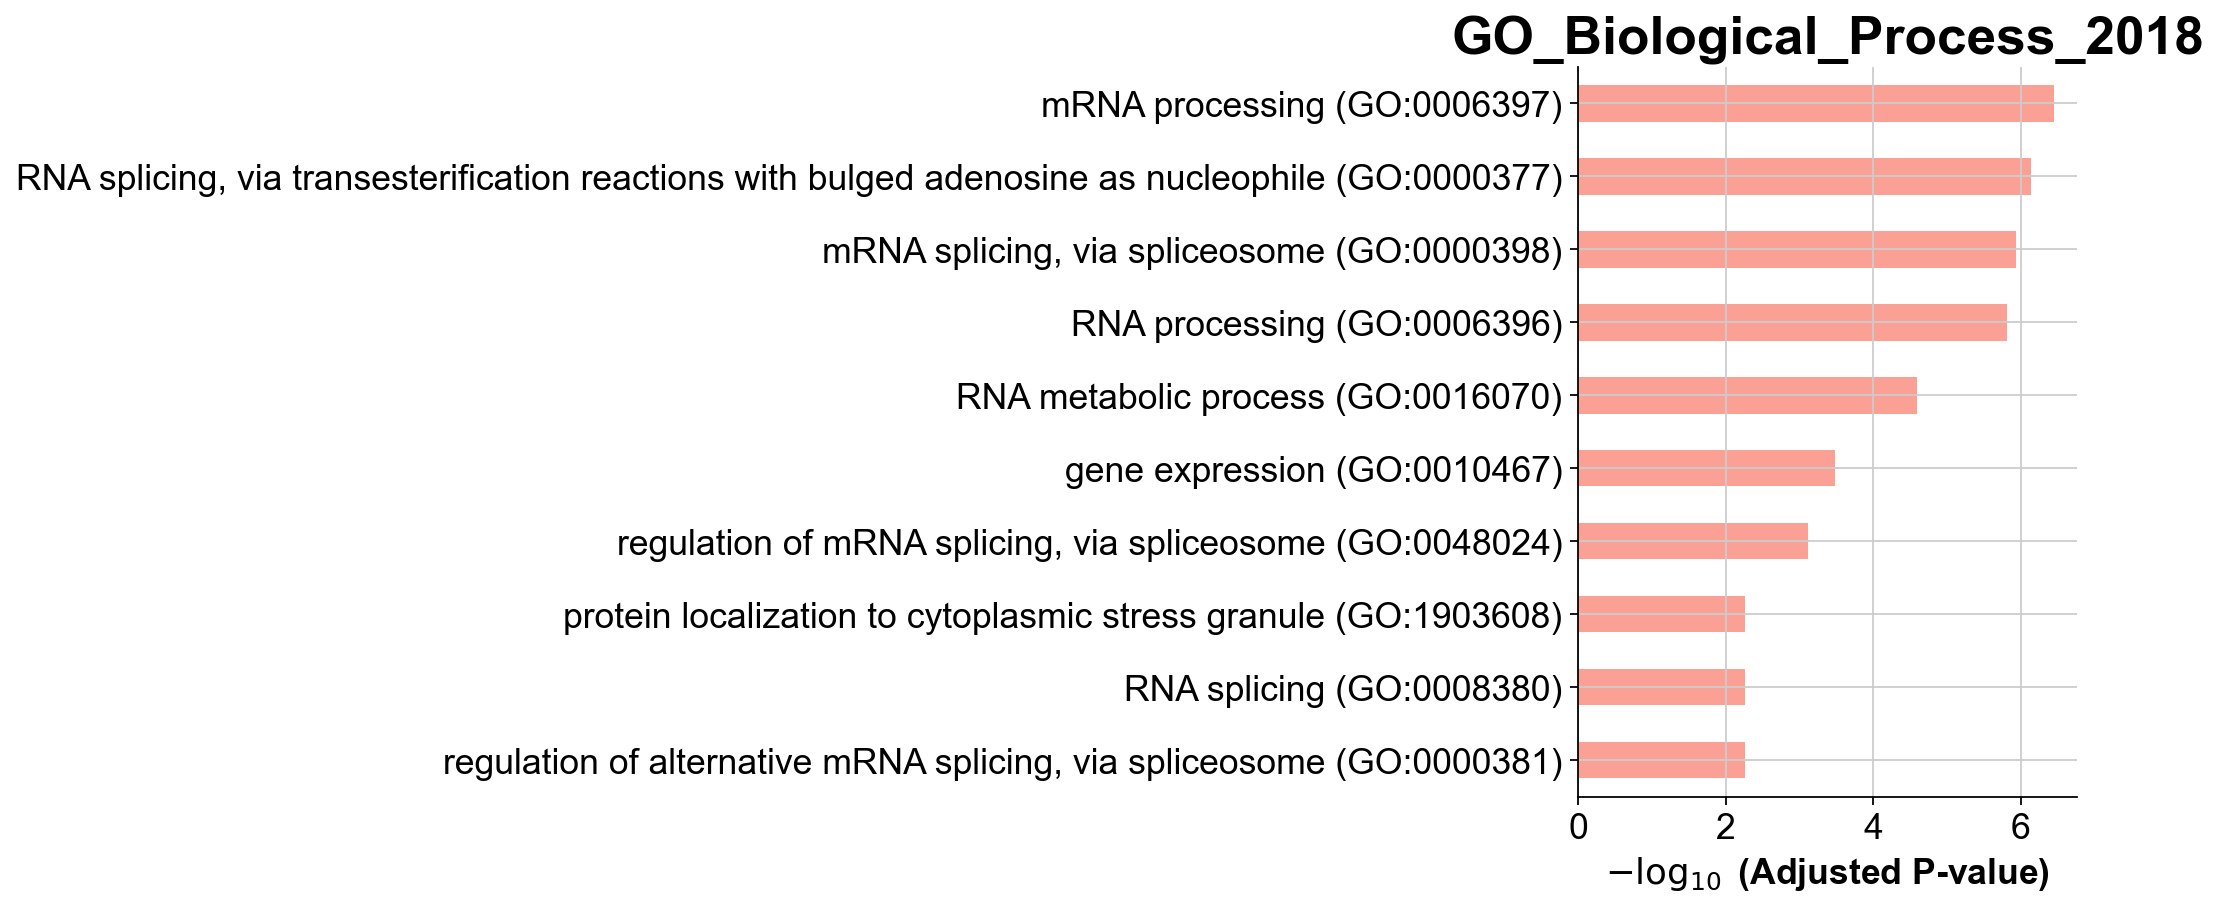

In [93]:
gseapy.barplot(enr_res.res2d,title='GO_Biological_Process_2018')

# 1.5  Gene Set Enrichment Analysis (GSEA)
Besides the enrichment using hypergeometric test, we can also perform gene set enrichment analysis (GSEA), which scores ranked genes list (usually based on fold changes) and computes permutation test to check if a particular gene set is more present in the Up-regulated genes, amongthe DOWN_regulated genes or not differentially regulated.

We need a table with all DEGs and their log foldchanges. However, many lowly expressed genes will have high foldchanges and just contribue noise, so also filter for expression in enough cells.

In [94]:
gene_rank = sc.get.rank_genes_groups_df(subset_sub, group=group1, key=method)[['names','logfoldchanges']]
gene_rank.sort_values(by=['logfoldchanges'], inplace=True, ascending=False)

In [98]:
# calculate_qc_metrics will calculate number of cells per gene
sc.pp.calculate_qc_metrics(subset, percent_top=None, log1p=False, inplace=True)

# filter for genes expressed in at least 30 cells.
gene_rank = gene_rank[gene_rank['names'].isin(subset.var_names[subset.var.n_cells_by_counts>30])]

In [99]:
gene_rank

names  logfoldchanges
387       TRBV11-2       27.579363
125           XIST       26.985525
292          GSTM1       26.335468
327          SATB1       26.232122
1621      TRBV10-3       25.799166
...            ...             ...
17492  RP5-862P8.2      -24.220228
17497        ZNF70      -24.221365
16884      SYNJ2BP      -24.223660
17491        MTURN      -24.351427
18269  TMX2-CTNND1      -25.102024

[20104 rows x 2 columns]

Once our list of genes are sorted, we can proceed with the enrichment itself. We can use the package to get gene set from the Molecular Signature Database (MSigDB) and select KEGG pathways as an example.

In [100]:
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(organism='Human')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'Diabetes_Perturbations_GEO_2022', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease

Next, we will be using the GSEA. This will result in a table containing information for several pathways. We can then sort and filter those pathways to visualize only the top ones. You can select/filter them by either p-value or normalized enrichemnet score (NES).

In [ ]:
res = gseapy.prerank(rnk=gene_rank, gene_sets='KEGG_2021_Human')

2023-03-09 00:18:17,576 [WARNING] Duplicated values found in preranked stats: 40.42% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [102]:
terms = res.res2d.Term
terms[:10]

0                          Olfactory transduction
1                    Steroid hormone biosynthesis
2                     Arachidonic acid metabolism
3             Complement and coagulation cascades
4                      Cardiac muscle contraction
5                              Taste transduction
6    Metabolism of xenobiotics by cytochrome P450
7                          Fanconi anemia pathway
8                            Pancreatic secretion
9                           Arginine biosynthesis
Name: Term, dtype: object

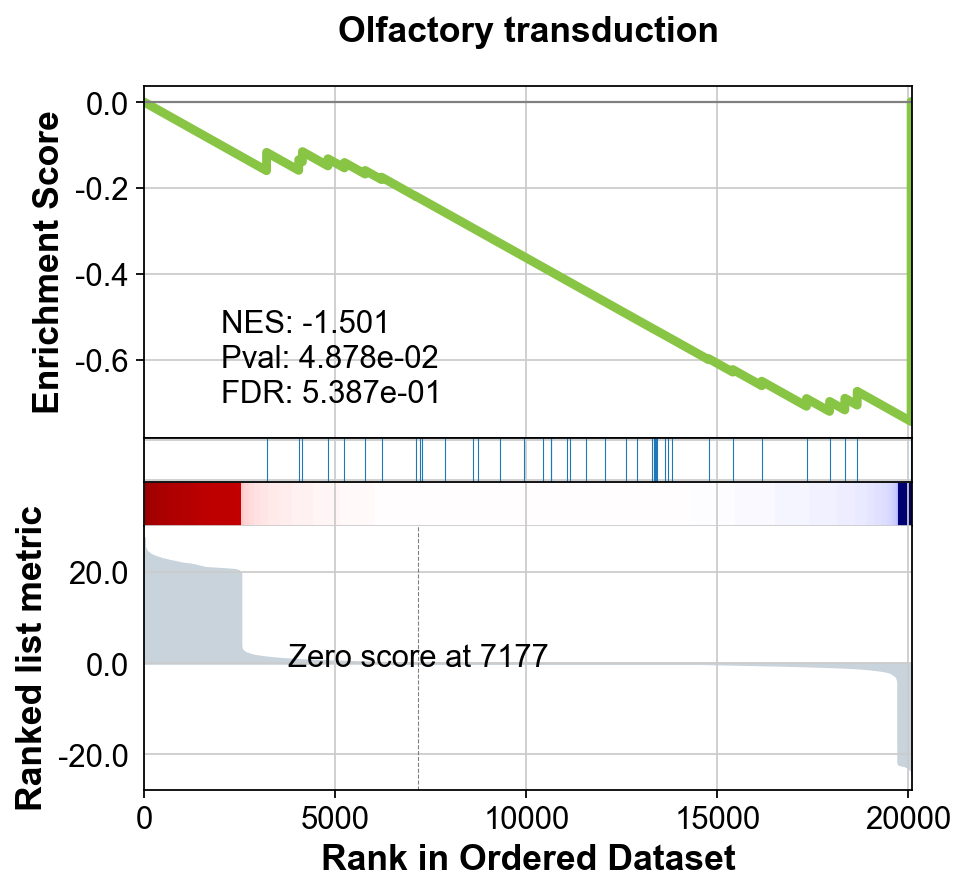

In [103]:
gseapy.gseaplot(rank_metric=res.ranking, term=terms[0], **res.results[terms[0]])

**Your turn** Which KEGG pathways are upregulated in this cluster? Which KEGG pathways are dowregulated in this cluster? Change the pathway source to another gene set (e.g. "CP:WIKIPATHWAYS" or "CP:REACTOME" or "CP:BIOCARTA" or "GO:BP") and check the if you get simmilar results?

## QC for TCR data
* ensure each barcode is associated with only 1 clonotype
* TODO: figure out how to create mapping from barcodes to clonotypes

In [29]:
# read in 1 sample TCR dataframe
ex_tcr_df = pd.read_csv("GSE125881_RAW/GSM3583877_CLL-1_IP-unpaired-clonotypes.csv.gz", compression="gzip", sep=",")

In [32]:
ex_tcr_df.head()

chain                                      clonotype_ids  \
0   TRB  clonotype1;clonotype5;clonotype1799;clonotype4...   
1   TRA  clonotype1;clonotype1799;clonotype4166;clonoty...   
2   TRB  clonotype2;clonotype18;clonotype952;clonotype2...   
3   TRA  clonotype2;clonotype65;clonotype952;clonotype2...   
4   TRA  clonotype3;clonotype441;clonotype1948;clonotyp...   

                                       consensus_ids  \
0  clonotype1_consensus_1;clonotype5_consensus_1;...   
1  clonotype1_consensus_2;clonotype1799_consensus...   
2  clonotype2_consensus_1;clonotype18_consensus_1...   
3  clonotype2_consensus_2;clonotype65_consensus_1...   
4  clonotype3_consensus_1;clonotype441_consensus_...   

                                            barcodes  \
0  AAACGGGCACGTAAGG-1;CTCGTCATCTGTTGAG-1;CTGCGGAC...   
1  ACCGTAAGTTGTGGAG-1;GGTGTTAGTATCAGTC-1;CACACAAG...   
2  GACGTGCAGGATGGAA-1;GATGAAAAGGGTGTTG-1;GATGAGGT...   
3  GACGTGCAGGATGGAA-1;TGCACCTGTTTAGGAA-1;AAGGCAGC...   
4  GCAAACTAGTCACGCC-1;AGTGGGATCGGTCTAA-1;ATCTACTG...   

                                          contig_ids                cdr3s  \
0  AAACGGGCACGTAAGG-1_contig_1;AAACGGGGTCCTCCAT-1...     CASSPNQHSGANVLTF   
1  AAACGGGCACGTAAGG-1_contig_4;AAACGGGGTCCTCCAT-1...     CLVGDMRTGGGNKLTF   
2  AACTGGTGTCTTCAAG-1_contig_1;AACTGGTGTTGAGGTG-1...  CSVEGVWQGTTNSGNTIYF   
3  AACTGGTGTCTTCAAG-1_contig_3;AACTGGTGTTGAGGTG-1...      CAVRALGGATNKLIF   
4  AAACGGGTCCTAGTGA-1_contig_2;AAATGCCTCGTCTGCT-1...          CAPDSSYKLIF   

                                            cdr3_nts   v_genes d_genes  \
0   TGTGCCAGCTCACCGAACCAGCACTCTGGGGCCAACGTCCTGACTTTC    TRBV18   TRBD2   
1   TGCCTCGTGGGTGACATGAGAACGGGAGGAGGAAACAAACTCACCTTT     TRAV4     NaN   
2  TGCAGCGTTGAAGGAGTGTGGCAGGGGACTACCAACTCTGGAAACA...  TRBV29-1   TRBD2   
3      TGTGCTGTGAGAGCCCTGGGTGGTGCTACAAACAAGCTCATCTTT     TRAV3     NaN   
4                  TGTGCCCCCGATAGCAGCTATAAATTGATCTTC    TRAV17     NaN   

   j_genes      c_genes  frequency  proportion  
0  TRBJ2-6  TRBC1;TRBC2        150    0.027634  
1   TRAJ10         TRAC        126    0.022573  
2  TRBJ1-3        TRBC1        112    0.020634  
3   TRAJ32         TRAC        104    0.018631  
4   TRAJ12         TRAC         95    0.017019

In [33]:
# Investigate whether the first two rows are the TCRB and TCRA barcodes associated with the same clonotype

example_tcrb_barcodes = set(ex_tcr_df.loc[0,"barcodes"].split(";")) 
example_tcra_barcides = set(ex_tcr_df.loc[1,"barcodes"].split(";"))

print(f"There are {len(example_tcrb_barcodes - example_tcra_barcides)} TCRB barcodes that are not in the TCRA barcodes")
print(f"There are {len(example_tcra_barcides - example_tcrb_barcodes)} TRCA barcodes that are not in the TCRB barcodes")

There are 24 TCRB barcodes that are not in the TCRA barcodes
There are 0 TRCA barcodes that are not in the TCRB barcodes


In [35]:
# Investigate whether there is a one-to-one mapping between 'clonotype ids' and 'barcodes' in a given row
# Seems likethere is not as there are way more barcodes than clonotypes
print(f"There are {len(ex_tcr_df.loc[0,'clonotype_ids'].split(';'))} clonotypes ids in the 0th row")
print(f"There are {len(ex_tcr_df.loc[0,'barcodes'].split(';'))} barcodes in the 0th row")

There are 11 clonotypes ids in the 0th row
There are 150 barcodes in the 0th row
